# Learning to Manipulate under Limited Information

### Requirement Installation (Linux, Python >=3.8)

In [1]:
# !pip3 install pref_voting # need at least version 0.4.42
# !pip3 install numba  # needed for pref_voting
# !pip3 install nashpy # needed for pref_voting
# !pip3 install seaborn
# !pip3 install multiprocess
# !pip3 install tqdm
# !pip3 install torch # https://pytorch.org/get-started/locally/

In [2]:
import pref_voting.generate_spatial_profiles
import pref_voting.generate_utility_profiles
import pref_voting.utility_profiles
import pref_voting.utility_functions
import pref_voting.voting_methods
import pref_voting.profiles
import pref_voting.generate_profiles
from pref_voting.generate_profiles import *
from pref_voting.iterative_methods import *
from pref_voting.analysis import means_with_estimated_standard_error
from functools import partial
import torch
import torch.nn as nn
import itertools

import matplotlib.pyplot as plt
import numpy as np

import math

import pickle
from tqdm.notebook import tqdm
from IPython.display import clear_output

import multiprocessing
import dill
import multiprocess

import glob
import os

import time
import datetime
import shutil

import pandas as pd
import seaborn as sns

from google.cloud import storage
import pickle
import zipfile
import os
import fnmatch

# Set-up for multiprocessing
dill.Pickler.dumps, dill.Pickler.loads = dill.dumps, dill.loads
multiprocessing.reduction.ForkingPickler = dill.Pickler
multiprocessing.reduction.dump = dill.dump
try:
    cpus = multiprocessing.cpu_count() - 1
except NotImplementedError:
    cpus = 2   # arbitrary default

# Set-up for timing
current_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=-7)))
CURRENT_TIME_STR = current_time.strftime("%m-%d-%Y_%H-%M-%S")

run_dir = None
DEVICE = 'cuda'  # change this to 'mps' to run on Apple Silicon

In [3]:
import pref_voting

print(pref_voting.__version__)

0.5.32


1. Setup
    * 1.1. Global variables
    * 1.2. Create directories
    * 1.3. Helper functions
    * 1.4. Agent class
    * 1.5. Manipulator information
    * 1.6. Labeling setup
        * 1.6.1. Satisficing
        * 1.6.2. Optimizing
    * 1.7. Validation setup
    * 1.8. Training setup
    * 1.9. Evaluation setup
2. Generate utility profiles
3. Generate labels
4. Train models
5. Evaluate models
6. Visualize results
    * 6.1. Performance by model size (Figure 3)
    * 6.2. Graphs to compare manipulator information types for a fixed model size (Figure 1)
    * 6.3. Graphs to compare across different numbers of candidates (Figure 2)
    * 6.4. Compare different generations of models
    * 6.5. Statistics about the number of models evaluated (Footnote 8)
    * 6.6. The total number of model evaluated

# 1. Setup

### 1.1. Global variables

In [4]:
DOWNLOAD_DATA = False # if true, then any missing utility profiles,  labels, and/or models will be downloaded from google cloud, unless the following variables are set to True. 
GENERATE_UTILITY_PROFILES = False
GENERATE_LABELS = False
TRAIN_MODELS = False

EVALUATE_MODELS = False
VISUALIZE_RESULTS = True

In [5]:
# How many generations to run
generation_list = [1]

# How many candidates will be in each election
num_cands_list = [3, 4, 5, 6]  

# How many voters will be in each election
num_voters_list = [5, 6, 10, 11, 20, 21]   

# Which models to use for sampling utility functions
prob_models_list = [
    'uniform', 
    #'spatial_2dim'
]

In [6]:
# What voting methods to study
voting_methods_list = [
    pref_voting.voting_methods.plurality,
    pref_voting.voting_methods.borda,
    pref_voting.voting_methods.instant_runoff,
    pref_voting.voting_methods.instant_runoff_put,
    pref_voting.voting_methods.minimax,
    pref_voting.voting_methods.split_cycle,
    pref_voting.voting_methods.strict_nanson,
    pref_voting.voting_methods.stable_voting,
]

# How much weight to give the manipulating voter. 
# manip_weight > 1 represents coalitional manipulation
manip_weight_list = [1]

# How rankings should be labeled
labeling_list = [
    #'satisfice',
    'optimize'
]

In [7]:
# What information will the manipulator know
agent_infos_list = [
    # ['full'], 
    # ['anon_prof'],
    ['plurality_scores'],
    # ['plurality_ranking'],
    # ['borda_scores'], 
    # ['margin'],
    # ['qual_margin'],
    ['majority'],
    # ['sincere_winners'],
    # ['plurality_scores, 'majority'], # List of multiple means that information will be concatenated together.
]

# Training hyperparameters
learning_rates = [6e-3]
max_num_iterations = 2000
training_batch_size = 512 
validation_batch_size = 4096 
validate_every = 20
patience = 10
threshold = .001

# Evaluation parameters
max_est_std_error = 0.0005
evaluation_batch_size = 4096
max_num_evaluation_rounds = 100

## 1.2. Create directories

In [8]:

# Create directories for saving results

os.makedirs(f'./training_utility_profiles', exist_ok=True)
os.makedirs(f'./validation_utility_profiles', exist_ok=True)
os.makedirs(f'./evaluation_utility_profiles', exist_ok=True)
os.makedirs(f'./labels', exist_ok=True)
os.makedirs(f'./models', exist_ok=True)
os.makedirs(f'./losses', exist_ok=True)
os.makedirs(f'./graphs', exist_ok=True)

for probmodel in prob_models_list:
    for labeling in labeling_list:
        for agent_infos in agent_infos_list:
            for manip_weight in manip_weight_list:
                os.makedirs(f'./models/models_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}', exist_ok=True)
                os.makedirs(f'./losses/losses_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}', exist_ok=True)
os.makedirs(f'./evaluation', exist_ok=True)
for probmodel in prob_models_list:
    for labeling in labeling_list:
        for agent_infos in agent_infos_list:
            for manip_weight in manip_weight_list:
                os.makedirs(f'./evaluation/evaluation_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}', exist_ok=True)


## Download Data 

In [9]:
def download_file(file_path):
    bucket_name = 'ltmdata'  
    dirs = file_path.split('/')
    filename = dirs[-1]
    dir = '/'.join(dirs[:-1])
    # if dir != '':
    #     dir += '/'

    storage_client = storage.Client.create_anonymous_client()

    blobs = storage_client.list_blobs(bucket_name, 
                                      prefix=dir, 
                                      delimiter=None)
    found_file = False
    for blob in blobs:
        # only download the file that matches the file_path
        if blob.name.endswith('zip') and fnmatch.fnmatch(blob.name, file_path + '.zip'):
            found_file = True
            with open(blob.name, 'wb') as file:
                blob.download_to_file(file)
            
            with zipfile.ZipFile(blob.name, 'r') as zip_ref:
                for file_info in zip_ref.infolist():
                    file_name = os.path.basename(file_info.filename)
                    # Skip directories
                    if not file_name:
                        continue
                    source = zip_ref.open(file_info)
                    target_file_path = os.path.join(dir, file_name)
                    with open(target_file_path, "wb") as target:
                        with source:
                            target.write(source.read())

            # delete the zip file from the local directory
            os.remove(blob.name)
    if found_file:    
        print("downloaded file")
        return True
    else:
        print("file not found")
        return False


In [10]:
def check_file(file_path):
    bucket_name = 'ltmdata'  
    dirs = file_path.split('/')
    filename = dirs[-1]
    dir = '/'.join(dirs[:-1])
    # if dir != '':
    #     dir += '/'

    storage_client = storage.Client.create_anonymous_client()

    blobs = storage_client.list_blobs(bucket_name, 
                                      prefix=dir, 
                                      delimiter=None)
    found_file = False
    for blob in blobs:
        # only download the file that matches the file_path
        if blob.name.endswith('zip') and fnmatch.fnmatch(blob.name, file_path + '.zip'):
            found_file = True
            print("file found")
    return found_file

In [11]:
if DOWNLOAD_DATA:
    print('Downloading data...\n\n')
    
    if not GENERATE_UTILITY_PROFILES:
        prof_types = [
            'evaluation', 
            'training', 
            'validation']
        for prof_type in prof_types:
            print(f'Checking {prof_type} utility profiles...\n')
            all_util_profiles_exist = list()
            for gen in generation_list:
                for num_cands in num_cands_list:
                    for num_voters in num_voters_list:
                        for probmodel in prob_models_list:
                            filename = f'{prof_type}_utility_profiles/{prof_type}_util_profs_{gen}_{num_cands}_{num_voters}_{probmodel}.pkl'
                            print(filename)
                            if os.path.isfile(filename):
                                print(f'already exists') 
                                found_file = True
                            else: 
                                #found_file = download_file(filename)
                                found_file = check_file(filename)

                            all_util_profiles_exist.append(found_file)
                            
            if all(all_util_profiles_exist):
                print(f'\nAll {prof_type} utility profiles exist.\n\n********\n')
            else: 
                print(f'\nNot all {prof_type} utility profiles exist.  You will need to generate the missing ones.\n\n********\n')

    if not GENERATE_LABELS:   
        print(f'Checking all labels...\n')
        all_labels_exist = list()
        for gen in generation_list:
            for num_cands in num_cands_list:
                for num_voters in num_voters_list:
                    for probmodel in prob_models_list:
                        for manip_weight in manip_weight_list:
                            for vm in voting_methods_list:
                                vm_name = vm.name
                                for labeling in labeling_list:
                                    filename = f'labels/labels_{gen}_{num_cands}_{num_voters}_{probmodel}_{manip_weight}_{vm_name}_{labeling}.pkl'
                                    print(filename)
                                    if os.path.isfile(filename):
                                        print(f'already exists') 
                                        found_file = True
                                    else: 
                                        found_file = check_file(filename)
                                        
                                    all_labels_exist.append(found_file)
                            
        if all(all_labels_exist):
            print(f'\nAll labels exist.\n\n********\n')
        else: 
            print(f'\nNot all labels exist.  You will need to generate the missing ones.\n\n********\n') 


    if not TRAIN_MODELS:   
        print(f'Checking all models...\n')
        all_models_exist = list()

        for agent_infos in agent_infos_list:
            for probmodel in prob_models_list:
                for labeling in labeling_list:
                    for manip_weight in manip_weight_list:
                        model_dir = f'models/models_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}'
                        os.makedirs(f'{model_dir}', exist_ok=True)
                        for vm in voting_methods_list:
                            vm_name = vm.name
                            for gen in generation_list: 
                                for num_cands in num_cands_list:
                                    for num_voters in num_voters_list:
                                        filename = f'{model_dir}/{vm_name}_{gen}_{num_cands}_{num_voters}_*.pickle'
                                        
                                        print(filename)

                                        # get all files matching this pattern
                                        files=glob.glob(filename)

                                        if len(files) == 1:
                                            print(f'already exists') 
                                            found_file = True
                                        elif len(files) > 1:
                                            print(f'found multiple model files')
                                            found_file = True
                                        else: # the file does not exist
                                            found_file = check_file(filename)
                                        
                                        all_models_exist.append(found_file)
        if all(all_models_exist):
            print(f'\nAll models exist.\n\n********\n')
        else: 
            print(f'\nNot all models exist.  You will need to generate the missing ones.\n\n********\n\n')   

## 1.3. Helper Functions

In [12]:
def generate_permutations(n):
    # Create a list from 0 to n-1
    num_list = list(range(n))

    # generate all permutations
    perms = list(itertools.permutations(num_list))

    return perms

permutations_of = dict()
permutations_of = {
    i: generate_permutations(i)
    for i in range(3, 7)
}

permutations_index_dict = {
    i : {
            tuple(permutations_of[i][j]) : j 
            for j in range(len(permutations_of[i]))
        }
    for i in range(3, 7)
}

In [13]:
print("All rankings for 3 candidates:\n", permutations_of[3])


All rankings for 3 candidates:
 [(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]


In [14]:
def to_linear_prof(uprof):
    # Convert utility profile to linear profile. 
    return pref_voting.profiles.Profile([sorted(uprof.domain, key=lambda x: u(x), reverse=True) for u in uprof.utilities])

def clone_voter(prof, manip_weight = 1):
    # Duplicate voter in profile (useful for coalitional manipulation)
    rankings, rcounts = prof.rankings_counts
    rcounts = list(rcounts)
    rankings = list([tuple(r) for r in rankings])
    new_rcounts = [rcounts[0] + (manip_weight - 1)] + rcounts[1:]
    return Profile(rankings, rcounts=new_rcounts)

def apply_manipulation(prof_with_clones, new_ranking, manip_weight):
    # Apply manipulation in profile with clones given a manipulation weight
    return pref_voting.profiles.Profile([new_ranking] * manip_weight + prof_with_clones.rankings[manip_weight:])


In [15]:
prof = pref_voting.generate_profiles.generate_profile(3, 4)

manip_weight = 1
print('Sincere profile:')
prof.display()
print('')
print('Apply manipulation (0, 1, 2):')
mprof = apply_manipulation(prof, (0, 1, 2), manip_weight)
mprof.display()


Sincere profile:
+---+---+
| 2 | 2 |
+---+---+
| 1 | 2 |
| 2 | 0 |
| 0 | 1 |
+---+---+

Apply manipulation (0, 1, 2):
+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 0 | 1 | 2 | 2 |
| 1 | 2 | 0 | 0 |
| 2 | 0 | 1 | 1 |
+---+---+---+---+


## 1.4. Agent Class

In [16]:
class Agent(nn.Module):
    def __init__(self, input_dim, output_dim, classification=False, layers=[128, 64, 32]):
        # Basic configurable MLP model.
        super().__init__()

        self.output_dim = math.factorial(output_dim)  # action space is [0, (output_dim)! - 1]

        module_list = []

        layers = [input_dim] + layers + [self.output_dim]

        for i in range(1, len(layers)):
            module_list.append(
                nn.Linear(layers[i - 1], layers[i]),
            )
            if i != len(layers) - 1:
                module_list.append(
                    nn.LeakyReLU(),
                )

        if classification:
            module_list.append(
                nn.Sigmoid(),
            )
        else:
            module_list.append(
                nn.Softmax(dim=-1),
            )

        self.model = nn.Sequential(*module_list)

        print(self.model)


    def forward(self, manipulator_utilities, additional_contexts): 
        # manipulator_utilities: [bs, n_c] (utility of voter 0)
        # additional_contexts: [bs, n_c]
        # returns (action_probs, action)

        context = torch.cat([manipulator_utilities, additional_contexts], dim=-1)

        action_probs = self.model(context)

        dist=torch.distributions.categorical.Categorical(probs=action_probs)
        actions = dist.sample()

        # action_probs: [BS, num_possible_actions]
        # actions: [BS,]
        return action_probs, actions

## 1.5. Manipulator Information

In [17]:
def generate_score_context(profs, scoring_rule = 'plurality', device=DEVICE):
    # generates score contexts from utility profile for each candidate
    #
    # scoring_rule: ('plurality', 'borda')
    # returns: [bs, num_cands]

    if scoring_rule == 'plurality':
        scores = [ prof.plurality_scores() for prof in profs] # list of dicts
    elif scoring_rule == 'borda':
        scores = [ prof.borda_scores() for prof in profs] # list of dicts

    final_scores = []
    for score in scores:

        scores_list = []
        for cand_index in sorted(score.keys()):
            scores_list.append(score[cand_index])

        final_scores.append(scores_list)

    return torch.tensor(
        final_scores,
        device=device,
    ) # [bs, num_cands]

def generate_majority_contexts(profs, num_cands, device=DEVICE):
    # generates majority matrix contexts
    # 
    # profs: list of profiles
    # outputs: [bs, num_cands * num_cands]

    bs = len(profs)
    
    contexts = torch.zeros((bs, num_cands, num_cands), device=device)
    
    for pidx, prof in enumerate(profs): 
        for c1 in prof.candidates: 
            for c2 in prof.candidates: 
                if prof.majority_prefers(c1, c2):
                    contexts[pidx, c1, c2] = 1.0
                elif prof.majority_prefers(c2, c1): 
                    contexts[pidx, c1, c2] = -1.0
                else:
                    contexts[pidx, c1, c2] = 0.0

    contexts = torch.flatten(contexts, start_dim=1) # [bs, num_cands * num_cands]
    return contexts


def generate_sincere_winners_contexts(profs, num_cands, vm, device=DEVICE):
    # generates sincere winners contexts
    # 
    # profs: list of profiles
    # vm: voting method function
    # outputs: [bs, num_cands] (one-hot encoding)

    bs = len(profs)

    contexts = torch.zeros((bs, num_cands), device=device)

    for pidx, prof in enumerate(profs):
        ws = vm(prof)
        for c in ws:
            contexts[pidx, c] = 1.0

    return contexts


In [18]:
def scores_to_qual_scores(scores):

    # sort the scores
    sorted_scores = sorted(list(set(scores)))

    return [sorted_scores.index(s) + 1 for s in scores]

def generate_score_ranking_context(profs, scoring_rule = 'plurality', device=DEVICE):
    # generates score rankings from utility profiles for each candidate
    #
    # profs: list of profiles
    # scoring_rule: ('plurality', 'borda')
    # returns: [bs, num_cands]

    if scoring_rule == 'plurality':
        scores = [ prof.plurality_scores() for prof in profs] # list of dicts
    elif scoring_rule == 'borda':
        scores = [ prof.borda_scores() for prof in profs] # list of dicts

    final_rankings = []
    for score in scores:

        scores_list = []
        for cand_index in sorted(score.keys()):
            scores_list.append(score[cand_index])

        final_rankings.append(scores_to_qual_scores(scores_list))

    return torch.tensor(
        final_rankings,
        device=device,
    ) # [bs, num_cands]

def generate_full_profile_contexts(profs, num_cands, num_voters, device=DEVICE):
    # generates full profile contexts
    # 
    # profs: list of profiles
    # outputs: [bs, num_voters * num_actions]

    bs = len(profs)
    
    action_space_size = math.factorial(num_cands)

    contexts = torch.zeros((bs, num_voters, action_space_size), device=device)

    # generate linear rankings as list comprehension

    for pidx, prof in enumerate(profs): 
        for ridx, r in enumerate(prof.rankings): 
            contexts[pidx, ridx, permutations_index_dict[num_cands][tuple(r)]] = 1.0

    contexts = torch.flatten(contexts, start_dim=1) # [bs, num_voters * num_actions]
    return contexts

def generate_anon_prof_contexts(profs, num_cands,  device=DEVICE):
    # generates anonymous profile contexts
    # 
    # profs: list of profiles
    # outputs: [bs, num_actions]

    bs = len(profs)
    
    action_space_size = math.factorial(num_cands)

    contexts = torch.zeros((bs, action_space_size), device=device)
    
    for pidx, prof in enumerate(profs):
        rankings, counts = prof.rankings_counts 
        for ridx, r in enumerate(rankings): 
            contexts[pidx, permutations_index_dict[num_cands][tuple(r)]] = counts[ridx]

    return contexts

def generate_margin_contexts(profs, num_cands, device=DEVICE):
    # generates margin matrix contexts
    # 
    # profs: list of profiles
    # outputs: [bs, num_cands * num_cands]

    bs = len(profs)
    
    contexts = torch.zeros((bs, num_cands, num_cands), device=device)
    
    for pidx, prof in enumerate(profs): 
        for c1 in prof.candidates: 
            for c2 in prof.candidates: 
                contexts[pidx, c1, c2] = prof.margin(c1, c2)

    contexts = torch.flatten(contexts, start_dim=1) # [bs, num_cands * num_cands]
    return contexts

def generate_qual_margin_contexts(profs, num_cands, device=DEVICE):
    # generates qualitative margin contexts
    # 
    # profs: list of profiles
    # outputs: [bs, num_cands * num_cands]

    bs = len(profs)
    
    contexts = torch.zeros((bs, num_cands, num_cands), device=device)
    
    for pidx, prof in enumerate(profs): 
        pos_margins = [prof.margin(c1, c2) for c1 in prof.candidates for c2 in prof.candidates if prof.margin(c1, c2) > 0]
        qual_pos_margins = scores_to_qual_scores(pos_margins)
        pos_margin_to_qual_margin = dict(zip(pos_margins, qual_pos_margins))
        for c1 in prof.candidates: 
            for c2 in prof.candidates: 
                if prof.margin(c1, c2) > 0:
                    contexts[pidx, c1, c2] = pos_margin_to_qual_margin[prof.margin(c1, c2)]
                elif prof.margin(c1, c2) < 0:
                    contexts[pidx, c1, c2] = -1.0 * pos_margin_to_qual_margin[-prof.margin(c1, c2)]
                else:
                    contexts[pidx, c1, c2] = 0.0

    contexts = torch.flatten(contexts, start_dim=1) # [bs, num_cands * num_cands]
    return contexts



## 1.6 Labeling Setup

### 1.6.1 Satisficing

In [19]:
def profitable_manipulations(vm, uprof, manip_weight):
    # Calculates all profitable manipulations for voter 0 in a utility profile

    u = uprof.utilities[0]
    prof = to_linear_prof(uprof)
    prof_with_clones = clone_voter(prof, manip_weight=manip_weight)
    strat_rankings = list()
    for new_r in itertools.permutations(prof.candidates):
        if new_r != prof.rankings[0]:
            new_prof = apply_manipulation(prof_with_clones, new_r, manip_weight)
            ws = vm(prof)
            new_ws = vm(new_prof)
            if ws != new_ws:
                exp_u_ws  = np.average([u(w) for w in ws])
                new_exp_u_ws = np.average([u(w) for w in new_ws])
                if new_exp_u_ws > exp_u_ws:
                    strat_rankings.append(new_r)
    return strat_rankings


def mask_manipulations(election, vm, manip_weight):
    # Generates the binary mask of which manipulations are
    # profitable.
    # 
    # election is a tuple of (utility_fn, profile)
    
    utility_fn, prof = election

    prof_with_clones = clone_voter(prof, manip_weight=manip_weight)

    output_mask = torch.zeros((math.factorial(len(prof.candidates)),))

    ws = vm(prof)
    exp_u_ws  = np.average([utility_fn(w) for w in ws])

    for i, new_r in enumerate(itertools.permutations(prof.candidates)):
        new_prof = apply_manipulation(prof_with_clones, new_r, manip_weight)

        new_ws = vm(new_prof)
        if new_ws == ws:
            output_mask[i] = 0.0
        else:
            new_exp_u_ws = np.average([utility_fn(w) for w in new_ws])
            if new_exp_u_ws > exp_u_ws:
                output_mask[i] = 1.0
            else:
                output_mask[i] = -1.0
    return output_mask


def generate_labels_reduced_actions(
    action_dists, 
    utility_fns, 
    profs, 
    num_cands, 
    vm, 
    manip_weight, 
    reduction_contexts=None
):
    # Reduce the distribution of actions (action_dists) to the probability
    # of choosing a profitable manipulation.

    # Returns: output_dists (bs, 2), output_labels (bs, 2)

    batch_size = len(profs)

    pool = multiprocess.Pool(processes=cpus)

    if reduction_contexts is None:
        manipulation_responses = pool.map(
            lambda x: mask_manipulations(x, vm, manip_weight),
            zip(utility_fns, profs)
        )

        masks = torch.stack(
            manipulation_responses
        ).to(action_dists.device) # [bs, num_actions]
    else:
        masks = reduction_contexts

    positive_mask = masks > 0 # [bs, num_actions]

    # check for places in the batch where there is no positive choice
    no_positive = ~positive_mask.any(dim=-1) # [bs, ]

    positive_mask[no_positive] = masks[no_positive] >= 0

    negative_mask = ~positive_mask


    output_dists = torch.zeros((batch_size, 2)).to(action_dists.device) # [pos, neg]

    output_dists[:, 0] = torch.sum(action_dists * positive_mask, dim=-1)
    output_dists[:, 1] = torch.sum(action_dists * negative_mask, dim=-1)

    output_labels = torch.zeros_like(output_dists)
    output_labels[:, 0] = 1.0

    return output_dists, output_labels

###  1.6.2. Optimizing

In [20]:
def find_best_response(election, vm, manip_weight):
    # Find best response(s) for voter 0 in an election
    # 
    # Return: list of best responses

    utility_fn, prof = election

    prof_with_clones = clone_voter(prof, manip_weight=manip_weight)

    ws = vm(prof)
    eu_ws = np.average([utility_fn(w) for w in ws])
    best_rankings = list()
    current_best_eu = eu_ws
    for new_ranking in itertools.permutations(prof.candidates):
        new_prof = apply_manipulation(prof_with_clones, new_ranking, manip_weight)
        new_ws = vm(new_prof)
        new_eu_ws = np.average([utility_fn(w) for w in new_ws])
        if new_eu_ws > current_best_eu:
            current_best_eu = new_eu_ws
            best_rankings = [new_ranking]
        elif new_eu_ws == current_best_eu:
            best_rankings.append(new_ranking)
    return best_rankings


def threaded_generate_classification_labels(utility_fns, profs, num_cands, vm, manip_weight):
    # generate labels for the optimize labeling.

    batch_size = len(profs)

    pool = multiprocess.Pool(processes=cpus)
    best_responses = pool.map(
        lambda x: find_best_response(x, vm, manip_weight),
        zip(utility_fns, profs)
        # zip(uprofs, [vm for _ in range(batch_size)]),
    )

    output = torch.zeros((batch_size, len(permutations_of[num_cands])))

    for i in range(batch_size):
        best_response = best_responses[i]
        for j, perm in enumerate(permutations_of[num_cands]):
            if perm in best_response:
                output[i, j] = 1.0

    return output


def generate_labels_reduced_actions_opt(
    action_dists, 
    utility_fns, 
    profs, 
    num_cands, 
    vm, 
    manip_weight, 
    reduction_contexts=None):
    # Reduce the distribution of actions (action_dists) to the probability
    # of choosing an optimal manipulation. 

    # Uses threaded_generate_classification_labels to generate the labels.

    # Returns: output_dists (bs, 2), output_labels (bs, 2)

    batch_size = len(profs)

    if reduction_contexts is None:
        optimal_labels = threaded_generate_classification_labels(
            utility_fns,
            profs,
            num_cands=num_cands, 
            vm=vm, 
            manip_weight=manip_weight
        ).to(action_dists.device)
    else:
        optimal_labels = reduction_contexts

    output_dists = torch.zeros((batch_size, 2)).to(action_dists.device) # [pos, neg]

    positive_mask = optimal_labels == 1
    negative_mask = ~positive_mask

    output_dists[:, 0] = torch.sum(action_dists * positive_mask, dim = -1)
    output_dists[:, 1] = torch.sum(action_dists * negative_mask, dim=-1)

    output_labels = torch.zeros_like(output_dists)
    output_labels[:, 0] = 1.0

    return output_dists, output_labels

## 1.7. Validation setup

In [21]:
def reward_function(
    actions, 
    utility_fns, 
    profs, 
    vm, 
    num_cands, 
    manip_weight, 
    metric_op='normalized_subtract'):
    # find the profitability of manipulation (as in Equation 4 from the paper)
    # for voter 0 in each profile.

    # actions = [BS,]
    # uprofs = list of uprofs
    # vm = voting method fn

    profs_with_clones = [clone_voter(prof, manip_weight=manip_weight) for prof in profs]

    ws_batch = [vm(prof) for prof in profs_with_clones]
    cands_batch = [prof.candidates for prof in profs_with_clones]

    exp_util_ws_batch = torch.tensor([
        np.average([utility_fn(w) for w in ws])
        for utility_fn, ws in zip(utility_fns, ws_batch)
    ]).float() # [BS,]
    exp_util_ws_batch = exp_util_ws_batch.to(DEVICE)

    max_util_batch = torch.tensor([
        np.max([utility_fn(c) for c in cands])
        for utility_fn, cands in zip(utility_fns, cands_batch)
    ]).float() # [BS,]
    max_util_batch = max_util_batch.to(DEVICE)

    min_util_batch = torch.tensor([
        np.min([utility_fn(c) for c in cands])
        for utility_fn, cands in zip(utility_fns, cands_batch)
    ]).float() # [BS,]
    min_util_batch = min_util_batch.to(DEVICE)

    new_profs = [
        apply_manipulation(prof, permutations_of[num_cands][action], manip_weight)
        for prof, action in zip(profs_with_clones, actions)
    ]

    new_ws_batch = [vm(new_prof) for new_prof in new_profs]
    
    new_exp_util_ws_batch = torch.tensor([
        np.average([utility_fn(w) for w in new_ws])
        for utility_fn, new_ws in zip(utility_fns, new_ws_batch)
    ]).float() # [BS,]

    new_exp_util_ws_batch = new_exp_util_ws_batch.to(DEVICE)

    if metric_op == 'subtract':
        reward = new_exp_util_ws_batch - exp_util_ws_batch
    elif metric_op == 'normalized_subtract':
        reward = (new_exp_util_ws_batch - exp_util_ws_batch) / (max_util_batch - min_util_batch)
    # create mask for which indices are different
    # add the cost to those indices

    return reward

In [22]:
def validation_function(
    agent, 
    batch_size, 
    vm, 
    num_cands, 
    num_voters, 
    manip_weight, 
    elections, 
    decision_rule='argmax', 
    metric_op="normalized_subtract", 
    agent_infos=('plurality_scores',)):
    # computes the profitability of submitted rankings chosen by 
    # the agent according to the decision_rule.

    manipulator_utility_fns, profiles = elections

    manipulator_utilities = torch.tensor(
        [
            [m_util_fn(i) for i in range(num_cands)]
            for m_util_fn in manipulator_utility_fns
        ],
    ).float().to(DEVICE)

    additional_contexts = None # guarantee that this is of shape [bs, x]

    additional_contexts = [] # guarantee that each entry is of shape [bs, x]

    for agent_info in agent_infos:
        additional_context = None

        if agent_info == 'full':
            additional_context = generate_full_profile_contexts(
                profiles,
                num_cands=num_cands,
                num_voters=num_voters,
                device=DEVICE
            )

        elif agent_info == 'anon_prof':
            additional_context = generate_anon_prof_contexts(
                profiles,
                num_cands=num_cands,
                device=DEVICE,
            )

        elif agent_info == 'plurality_scores':

            additional_context = generate_score_context(
                profiles,
                scoring_rule='plurality',
                device=DEVICE,
            ).float()
            
        elif agent_info == 'plurality_ranking':

            additional_context = generate_score_ranking_context(
                profiles,
                scoring_rule='plurality',
                device=DEVICE,
            ).float()
            
        elif agent_info == 'borda_scores':
            additional_context = generate_score_context(
                profiles,
                scoring_rule='borda',
                device=DEVICE,
            ).float()

        elif agent_info == 'margin':
            additional_context = generate_margin_contexts(
                profiles,
                num_cands=num_cands,
                device=DEVICE
            )
        elif agent_info == 'qual_margin':
            additional_context = generate_qual_margin_contexts(
                profiles,
                num_cands=num_cands,
                device=DEVICE
            )

        elif agent_info == 'majority':
            additional_context = generate_majority_contexts(
                profiles,
                num_cands=num_cands,
                device=DEVICE
            )


        elif agent_info == 'sincere_winners':
            additional_context = generate_sincere_winners_contexts(
                profiles,
                num_cands=num_cands,
                vm=vm,
                device=DEVICE
            )
            
        additional_contexts.append(additional_context)

    additional_contexts = torch.cat(additional_contexts, dim=-1)

    action_probs_batch, actions_batch = agent(manipulator_utilities, additional_contexts)

    if decision_rule == 'expectation':

        eval_result = torch.zeros((batch_size,)).to(DEVICE)

        for i in range(action_probs_batch.shape[-1]):
            actions_batch = torch.ones_like(actions_batch) * i

            reward_val = reward_function(
                actions=actions_batch,
                utility_fns=manipulator_utility_fns,
                profs=profiles,
                vm=vm,
                num_cands=num_cands,
                manip_weight=manip_weight,
                metric_op=metric_op,
            )

            eval_result += reward_val * action_probs_batch[:, i]
    elif decision_rule == 'argmax':
        # using the argmax
        actions_batch = torch.argmax(action_probs_batch, dim=-1)
        eval_result = reward_function(
                actions=actions_batch,
                utility_fns=manipulator_utility_fns,
                profs=profiles,
                vm=vm,
                num_cands=num_cands,
                manip_weight=manip_weight,
                metric_op=metric_op,
            )
    elif decision_rule == 'distribution':
        eval_result = reward_function(
            actions=actions_batch,
            utility_fns=manipulator_utility_fns,
            profs=profiles,
            vm=vm,
            num_cands=num_cands,
            manip_weight=manip_weight,
            metric_op=metric_op,
        )
    else:
        raise Exception("pick one")
    
    return eval_result


## 1.8. Training setup

In [23]:
def train_strategy_classification(
        num_voters, 
        num_candidates, 
        training_elections,
        validation_elections,
        model_size=[128, 64, 32], 
        vm=pref_voting.voting_methods.plurality,
        max_num_iterations = 2000,
        validate_every = 20, 
        reduction_contexts = None, 
        training_batch_size = 512, 
        validation_batch_size = 4096, 
        patience = 20, 
        threshold = 0.001, 
        learning_rate = 6e-3, 
        labeling='satisfice', 
        agent_infos=[('plurality_scores',)], 
        manip_weight = 1):  
    # the main training function, including periodic validation checks. 

    input_dim = 0

    input_dim += num_candidates

    agent_infos = sorted(agent_infos)

    # additional input dimension for each type of context
    dim_additions = {
        'full': num_voters * math.factorial(num_candidates),
        'anon_prof':  math.factorial(num_candidates),
        'plurality_scores': num_candidates,
        'plurality_ranking': num_candidates,
        'borda_scores': num_candidates,
        'margin': num_candidates * num_candidates,
        'qual_margin': num_candidates * num_candidates,
        'majority': num_candidates * num_candidates,
        'sincere_winners': num_candidates,
    }

    for agent_info in agent_infos:
        input_dim += dim_additions[agent_info]

    # Create agent
    agent = Agent(
        input_dim=input_dim,
        output_dim=num_candidates, classification=False,
        layers=model_size,
    )

    agent = agent.to(DEVICE)

    loss_fn = nn.MSELoss()

    # set up optimizer
    optimizer = torch.optim.Adam(
        agent.parameters(),
        learning_rate, 
    )

    train_losses = []
    train_evals = []
    #assert len(elections[0]) >= max_num_iterations * batch_size and len(elections[0]) == len(elections[1])

    best_eval = float('-inf')
    patience_counter = 0
    val_iter = 0
    for iter in tqdm(range(max_num_iterations)):

        #print("[INFO] iter: {}...".format(iter + 1))

        # build batch up

        iter_training_elections = (
            training_elections[0][iter * training_batch_size: iter * training_batch_size + training_batch_size],
            training_elections[1][iter * training_batch_size: iter * training_batch_size + training_batch_size]
        )

        iter_manipulator_utility_functions = iter_training_elections[0]
        iter_profiles = iter_training_elections[1]

        iter_reduction_contexts = reduction_contexts[iter * training_batch_size: iter * training_batch_size + training_batch_size]
        
        manipulator_utilities = torch.tensor(
            [
                [m_util_fn(i) for i in range(num_candidates)]
                for m_util_fn in iter_manipulator_utility_functions
            ],
        ).float().to(DEVICE)

        additional_contexts = [] # guarantee that each entry is of shape [bs, x]

        for agent_info in agent_infos:
            additional_context = None

            if agent_info == 'full':
                additional_context = generate_full_profile_contexts(
                    iter_profiles,
                    num_cands=num_candidates,
                    num_voters=num_voters,
                    device=DEVICE
                )

            elif agent_info == 'anon_prof':
                additional_context = generate_anon_prof_contexts(
                    iter_profiles,
                    num_cands=num_candidates,
                    device=DEVICE,
                )

            elif agent_info == 'plurality_scores':

                additional_context = generate_score_context(
                    iter_profiles,
                    scoring_rule='plurality',
                    device=DEVICE,
                ).float()
                
            elif agent_info == 'borda_scores':
                additional_context = generate_score_context(
                    iter_profiles,
                    scoring_rule='borda',
                    device=DEVICE,
                ).float()

            elif agent_info == 'plurality_ranking':

                additional_context = generate_score_ranking_context(
                    iter_profiles,
                    scoring_rule='plurality',
                    device=DEVICE,
                ).float()

            elif agent_info == 'margin':
                additional_context = generate_margin_contexts(
                    iter_profiles,
                    num_cands=num_candidates,
                    device=DEVICE
                )

            elif agent_info == 'majority':
                additional_context = generate_majority_contexts(
                    iter_profiles,
                    num_cands=num_candidates,
                    device=DEVICE
                )
            elif agent_info == 'qual_margin':
                additional_context = generate_qual_margin_contexts(
                    iter_profiles,
                    num_cands=num_candidates,
                    device=DEVICE
                )

            elif agent_info == 'sincere_winners':
                additional_context = generate_sincere_winners_contexts(
                    iter_profiles,
                    num_cands=num_candidates,
                    vm=vm,
                    device=DEVICE
                )
            
            additional_contexts.append(additional_context)

        additional_contexts = torch.cat(additional_contexts, dim=-1)

        optimizer.zero_grad()

        # get agent actions
        action_probs_batch, actions_batch = agent(manipulator_utilities, additional_contexts)

        # print(action_probs_batch)

        if labeling == 'satisfice':

            reduced_actions, labels = generate_labels_reduced_actions(
                action_probs_batch, 
                iter_manipulator_utility_functions,
                iter_profiles,
                num_candidates, 
                vm=vm,
                manip_weight=manip_weight,
                reduction_contexts=iter_reduction_contexts,
            )

        elif labeling == 'optimize':

            reduced_actions, labels = generate_labels_reduced_actions_opt(
                action_probs_batch, 
                iter_manipulator_utility_functions,
                iter_profiles,
                num_candidates, 
                vm=vm,
                manip_weight=manip_weight,
                reduction_contexts=iter_reduction_contexts,
            )

        loss = loss_fn(reduced_actions, labels)
        #print("loss:", loss.item())

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        if (iter + 1) % validate_every == 0:
            with torch.no_grad():
                agent.eval()
                iter_validation_elections = (
                validation_elections[0][val_iter * validation_batch_size: val_iter * validation_batch_size + validation_batch_size],
                validation_elections[1][val_iter * validation_batch_size: val_iter * validation_batch_size + validation_batch_size]
                )
                iter_evals = validation_function(agent, validation_batch_size, vm, num_candidates, num_voters, manip_weight, iter_validation_elections, decision_rule='argmax',metric_op="normalized_subtract", agent_infos=agent_infos)
                iter_eval = iter_evals.mean().cpu().detach().numpy()
                print("iter_eval", iter_eval)
                train_evals.append(iter_eval)

                val_iter += 1

                if iter_eval - best_eval > threshold: 
                    best_eval = iter_eval
                    patience_counter = 0
                    best_agent = copy.deepcopy(agent)
                    best_losses = train_losses
                    best_evals = train_evals
                else: 
                    patience_counter += 1

                if patience_counter >= patience: 
                    print("best eval is ", best_eval)
                    break
            agent.train()
    
    return best_agent, best_losses, best_evals

## 1.9. Evaluation setup

In [24]:
def evaluation_function(
    agent, 
    vm, 
    num_cands, 
    num_voters, 
    manip_weight, 
    all_utility_profs, 
    decision_rule, 
    metric_op, 
    agent_infos, 
    num_samples, 
    step):
    # evaluate the trained agent's submitted rankings

    utility_profiles = all_utility_profs[num_samples*step:num_samples*(step+1)]

    manipulator_utility_fns = [uprof.utilities[0] for uprof in utility_profiles]
    profiles = [to_linear_prof(uprof) for uprof in utility_profiles]

    manipulator_utilities = torch.tensor(
        [
            [m_util_fn(i) for i in range(num_cands)]
            for m_util_fn in manipulator_utility_fns
        ],
    ).float().to(DEVICE)

    additional_contexts = None # guarantee that this is of shape [bs, x]

    additional_contexts = [] # guarantee that each entry is of shape [bs, x]

    for agent_info in agent_infos:
        additional_context = None

        if agent_info == 'full':
            additional_context = generate_full_profile_contexts(
                profiles,
                num_cands=num_cands,
                num_voters=num_voters,
                device=DEVICE
            )

        elif agent_info == 'anon_prof':
            additional_context = generate_anon_prof_contexts(
                profiles,
                num_cands=num_cands,
                device=DEVICE,
            )

        elif agent_info == 'plurality_scores':

            additional_context = generate_score_context(
                profiles,
                scoring_rule='plurality',
                device=DEVICE,
            ).float()
            
        elif agent_info == 'plurality_ranking':

            additional_context = generate_score_ranking_context(
                profiles,
                scoring_rule='plurality',
                device=DEVICE,
            ).float()
            
        elif agent_info == 'borda_scores':
            additional_context = generate_score_context(
                profiles,
                scoring_rule='borda',
                device=DEVICE,
            ).float()

        elif agent_info == 'margin':
            additional_context = generate_margin_contexts(
                profiles,
                num_cands=num_cands,
                device=DEVICE
            )
        elif agent_info == 'qual_margin':
            additional_context = generate_qual_margin_contexts(
                profiles,
                num_cands=num_cands,
                device=DEVICE
            )

        elif agent_info == 'majority':
            additional_context = generate_majority_contexts(
                profiles,
                num_cands=num_cands,
                device=DEVICE
            )

        elif agent_info == 'sincere_winners':
            additional_context = generate_sincere_winners_contexts(
                profiles,
                num_cands=num_cands,
                vm=vm,
                device=DEVICE
            )
            
        additional_contexts.append(additional_context)

    additional_contexts = torch.cat(additional_contexts, dim=-1)

    action_probs_batch, actions_batch = agent(manipulator_utilities, additional_contexts)

    if decision_rule == 'argmax':
        actions_batch = torch.argmax(action_probs_batch, dim=-1)
        eval_result = reward_function(
                actions=actions_batch,
                utility_fns=manipulator_utility_fns,
                profs=profiles,
                vm=vm,
                num_cands=num_cands,
                manip_weight=manip_weight,
                metric_op=metric_op,
            )

    elif decision_rule == 'distribution':
        eval_result = reward_function(
            actions=actions_batch,
            utility_fns=manipulator_utility_fns,
            profs=profiles,
            vm=vm,
            num_cands=num_cands,
            manip_weight=manip_weight,
            metric_op=metric_op,
        )

    else:
        raise Exception("pick one")
    
    return np.array([eval_result.cpu().detach().numpy()])


# 2. Generate utility profiles

In [25]:
def generate_utility_profile(
    num_cands, 
    num_voters, 
    probmodel = 'uniform', 
    num_profiles = 1
):
    # Generate utility profiles
    # 
    # probmodel = ('uniform', 'spatial_2dim')
    # Return: list of utility profiles

    if probmodel == 'uniform': 
        return pref_voting.generate_utility_profiles.generate_utility_profile_uniform(num_cands, num_voters, num_profiles = num_profiles)
    
    elif probmodel == 'spatial_2dim':
        ndims = 2
        sprofs = pref_voting.generate_spatial_profiles.generate_spatial_profile(num_cands, num_voters, ndims, num_profiles = num_profiles)
        return [sprof.to_utility_profile() for sprof in sprofs]

In [26]:
# generate utility profiles for training, validation, and evaluation 
# and save them to disk as pickle files

np.random.seed(0)

training_utility_base_dir = "training_utility_profiles"
validation_utility_base_dir = "validation_utility_profiles"
evaluation_utility_base_dir = "evaluation_utility_profiles"

if GENERATE_UTILITY_PROFILES:

    os.makedirs(training_utility_base_dir, exist_ok=True)
    os.makedirs(validation_utility_base_dir, exist_ok=True)
    os.makedirs(evaluation_utility_base_dir, exist_ok=True)

    for probmodel in prob_models_list:
        for num_cands in num_cands_list:
            for num_voters in num_voters_list:
                
                # creating training utility profiles.

                total_utility_profiles = generate_utility_profile(
                    num_cands, 
                    num_voters, 
                    probmodel = probmodel, 
                    num_profiles = training_batch_size * max_num_iterations * len(generation_list))
                
                for gen_idx, gen in enumerate(generation_list):

                    start_index = gen_idx * training_batch_size * max_num_iterations
                    end_index = (gen_idx + 1) * training_batch_size * max_num_iterations

                    elections = total_utility_profiles[start_index: end_index] 
                    pickle.dump(
                        elections, 
                        open(
                            os.path.join(
                                training_utility_base_dir,
                                f"training_util_profs_{gen}_{num_cands}_{num_voters}_{probmodel}.pkl",
                            ), "wb",
                        ),   
                    )

                # creating validation utility profiles
                total_utility_profiles = generate_utility_profile(
                    num_cands, 
                    num_voters, 
                    probmodel = probmodel, 
                    num_profiles = validation_batch_size * math.ceil(max_num_iterations / validate_every) * len(generation_list))

                for gen_idx, gen in enumerate(generation_list):

                    start_index = gen_idx * validation_batch_size * math.ceil(max_num_iterations / validate_every)
                    end_index = (gen_idx + 1) * validation_batch_size * math.ceil(max_num_iterations / validate_every)

                    elections = total_utility_profiles[start_index: end_index] 
                    pickle.dump(
                        elections, 
                        open(
                            os.path.join(
                                validation_utility_base_dir,
                                f"validation_util_profs_{gen}_{num_cands}_{num_voters}_{probmodel}.pkl",
                            ), "wb",
                        ),   
                    )

                # creating evaluation utility profiles
                total_utility_profiles = generate_utility_profile(
                    num_cands, 
                    num_voters, 
                    probmodel = probmodel, 
                    num_profiles = evaluation_batch_size * max_num_evaluation_rounds *  len(generation_list))

                for gen_idx, gen in enumerate(generation_list):

                    start_index = gen_idx * evaluation_batch_size * max_num_evaluation_rounds
                    end_index = (gen_idx + 1) * evaluation_batch_size * max_num_evaluation_rounds

                    elections = total_utility_profiles[start_index: end_index] 
                    pickle.dump(
                        elections, 
                        open(
                            os.path.join(
                                evaluation_utility_base_dir,
                                f"evaluation_util_profs_{gen}_{num_cands}_{num_voters}_{probmodel}.pkl",
                            ), "wb",
                        ),   
                    )


# 3. Generate labels

In [27]:
# generate the labels for the stored training profiles 
# and save to disk as pickle files. 

if GENERATE_LABELS:        
    for gen in generation_list:
        for probmodel in prob_models_list:
            for num_cands in num_cands_list:
                for num_voters in num_voters_list:

                    utility_profiles = pickle.load(
                        open(
                            os.path.join(
                                training_utility_base_dir,
                                f"training_util_profs_{gen}_{num_cands}_{num_voters}_{probmodel}.pkl",
                            ), "rb",
                        ),
                        )

                    elections = (
                        [uprof.utilities[0] for uprof in utility_profiles],
                        [to_linear_prof(uprof) for uprof in utility_profiles],
                    )
                                
                    for manip_weight in manip_weight_list:
                        for vm in voting_methods_list:
                            for labeling in labeling_list:

                                labels_dict = {} 

                                print("Generation:", gen)
                                print("Num cands:", num_cands)
                                print("Num voters:", num_voters)
                                print("Prob model:", probmodel)
                                print("Manip weight:", manip_weight)
                                print("Voting method:", vm.name)
                                print("Labeling:", labeling)
                                print("")

                                if labeling == 'satisfice':
                                    pool = multiprocess.Pool(processes=cpus)
                                    manipulation_responses = pool.map(
                                        lambda x: mask_manipulations(x, vm, manip_weight),
                                        zip(*elections),
                                    )

                                    masks = torch.stack(
                                        manipulation_responses
                                    ).to("cpu") # [bs, num_actions]

                                    reduction_contexts = masks

                                elif labeling == 'optimize':
                                    reduction_contexts = threaded_generate_classification_labels(
                                        utility_fns=elections[0],
                                        profs=elections[1], 
                                        num_cands=num_cands,
                                        vm=vm, 
                                        manip_weight=manip_weight,
                                        ).to("cpu")
                                
                                pickle.dump(reduction_contexts, open(f"labels/labels_{gen}_{num_cands}_{num_voters}_{probmodel}_{manip_weight}_{vm.name}_{labeling}.pkl", "wb"))

# 4. Train models

In [28]:
def create_run_directory():
    # helper function to create a run directory
    
    current_time = datetime.datetime.now(datetime.timezone(datetime.timedelta(hours=-7)))
    current_time_str = current_time.strftime("%m-%d-%Y_%H-%M-%S")
    run_dir = os.path.join(os.getcwd(), "run_of_{}".format(current_time_str))
    os.mkdir(run_dir)
    os.mkdir(os.path.join(run_dir, "models"))
    os.mkdir(os.path.join(run_dir, "torch_models"))
    os.mkdir(os.path.join(run_dir, "losses"))
    os.mkdir(os.path.join(run_dir, "validation"))
    os.mkdir(os.path.join(run_dir, "evaluation"))
    os.mkdir(os.path.join(run_dir, "graphs"))
    return run_dir

In [29]:
# used the stored training and validation profiles and 
# the stored labels to train models with configurations 
# from model_size_lists 

if TRAIN_MODELS: 
    run_dir = create_run_directory()
    print(run_dir)

    model_size_lists = [
        [4],
        [8],
        [16],
        [32],
        [64],
        [128],
        [256],
        [512],

        [4,4],
        [8,8],
        [16,8],
        [16,16],
        [32,32],
        [64,32],
        [64,64],
        [128,128],
        [256,128],
        [256,256],

        [8,8,8],
        [32,16,8],
        [32,32,32],
        [64,64,64],
        [128,64,32],
        [128,128,128],
        [256,256,256],
        [512,256,128],
    ]

    for gen in generation_list:
        for probmodel in prob_models_list:
            for num_cands in num_cands_list:
                for num_voters in num_voters_list: 
                    
                    training_utility_profiles = pickle.load(
                        open(
                            os.path.join(
                                training_utility_base_dir,
                                f"training_util_profs_{gen}_{num_cands}_{num_voters}_{probmodel}.pkl",
                            ), "rb",
                        ),
                    )

                    training_elections = (
                        [uprof.utilities[0] for uprof in training_utility_profiles],
                        [to_linear_prof(uprof) for uprof in training_utility_profiles],
                    )

                    validation_utility_profiles = pickle.load(
                        open(
                            os.path.join(
                                validation_utility_base_dir,
                                f"validation_util_profs_{gen}_{num_cands}_{num_voters}_{probmodel}.pkl",
                            ), "rb",
                        ),
                    )

                    validation_elections = (
                        [uprof.utilities[0] for uprof in validation_utility_profiles],
                        [to_linear_prof(uprof) for uprof in validation_utility_profiles],
                    )

                    print("len(validation_elections[0])", len(validation_elections[0]))
                    print("len(validation_elections[1])", len(validation_elections[1]))
                    for manip_weight in manip_weight_list:
                        for agent_infos in agent_infos_list:
                            for vm in voting_methods_list:
                                results_dict = {}

                                for labeling in labeling_list:

                                    reduction_contexts = pickle.load(
                                        open(
                                            f"labels/labels_{gen}_{num_cands}_{num_voters}_{probmodel}_{manip_weight}_{vm.name}_{labeling}.pkl", 
                                            "rb",
                                        ),
                                    )
                                    
                                    reduction_contexts = reduction_contexts.to(DEVICE)
                                    
                                    for model_size in model_size_lists:
                                        for learning_rate in learning_rates:
                                            
                                            print("Generation:", gen)
                                            print("Num cands:", num_cands)
                                            print("Num voters:", num_voters)
                                            print("Prob model:", probmodel)
                                            print("Manip weight:", manip_weight)
                                            print("Voting method:", vm.name)
                                            print("Labeling:", labeling)
                                            print("Agent info:", agent_infos)
                                            print("Learning rate:", learning_rate)
                                            print("")


                                            torch.manual_seed(144 + gen)
                                            np.random.seed(144 + gen)

                                            agent, losses, evals = train_strategy_classification(
                                                num_voters=num_voters,
                                                num_candidates=num_cands,
                                                training_elections=training_elections,
                                                validation_elections=validation_elections,
                                                model_size=model_size,
                                                vm=vm,
                                                max_num_iterations = max_num_iterations,
                                                validate_every=validate_every,
                                                reduction_contexts=reduction_contexts,
                                                training_batch_size=training_batch_size,
                                                validation_batch_size=validation_batch_size,
                                                learning_rate = learning_rate,
                                                labeling=labeling,
                                                agent_infos=agent_infos,
                                                manip_weight=manip_weight,
                                                patience = patience,
                                            )

                                            torch.save(agent,
                                                os.path.join(
                                                    f'{run_dir}/torch_models', 
                                                    f'{vm.name}_{gen}_{num_cands}_{num_voters}_{probmodel}_{learning_rate}_{tuple(model_size)}_{max_num_iterations}_{labeling}_{tuple(agent_infos)}_{manip_weight}.pth', 
                                                )  
                                            )

                                            results_dict[
                                                (vm.name, gen, tuple(model_size), num_cands, num_voters, probmodel, learning_rate, training_batch_size, max_num_iterations, labeling, tuple(agent_infos), manip_weight)
                                            ] = (agent.to("cpu"), losses)
                                            print('len(evals)', len(evals))
                                            plt.plot(losses, label="loss")
                                            plt.plot([((i+1) * validate_every) - 1 for i in range(len(evals))], evals, label="evals")
                                            plt.legend()
                                            plt.title(f"{vm.name}, {gen}, {tuple(model_size)}, {num_cands}, {num_voters}, {probmodel}, {learning_rate}, {training_batch_size}, {max_num_iterations}, {labeling}, {tuple(agent_infos)}, {manip_weight}")

                                            plt.savefig(f'{run_dir}/losses/{vm.name}_{gen}_{num_cands}_{num_voters}_{probmodel}_{learning_rate}_{tuple(model_size)}_{max_num_iterations}_{labeling}_{tuple(agent_infos)}_{manip_weight}_{CURRENT_TIME_STR}.png')

                                            plt.savefig(f'losses/losses_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/{vm.name}_{gen}_{num_cands}_{num_voters}_{probmodel}_{learning_rate}_{tuple(model_size)}_{max_num_iterations}_{labeling}_{tuple(agent_infos)}_{manip_weight}_{CURRENT_TIME_STR}.png')

                                            plt.close()

                                            clear_output(wait=True)

                                    with open(f'{run_dir}/models/{vm.name}_{gen}_{num_cands}_{num_voters}_{probmodel}_{tuple(agent_infos)}_{manip_weight}_{CURRENT_TIME_STR}.pickle', 'wb') as handle:
                                        pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)                        
                                    with open(f'models/models_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/{vm.name}_{gen}_{num_cands}_{num_voters}_{probmodel}_{tuple(agent_infos)}_{manip_weight}_{CURRENT_TIME_STR}.pickle', 'wb') as handle:
                                        pickle.dump(results_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 5. Evaluate models

In [30]:
def evaluate_models(
        models_dict, 
        num_cands, 
        num_voters, 
        probmodel, 
        all_utility_profs, 
        min_num_trials, 
        max_num_trials, 
        decision_rule, 
        metric_op):
    # evaluate all models in models_dict using all_utility_profs
    # the number of profiles used for evaluation is determined by 
    # repeated application of the percentile bootstrap method 
    # for determining confidence intervals (see https://pref-voting.readthedocs.io/en/latest/analysis_overview.html#pref_voting.analysis.bootstrap_cia)

    vm_dict = {
        vm.name : vm for vm in voting_methods_list
    }

    metrics_dict = {}

    for key in tqdm(models_dict.keys()):
        
        if num_cands == key[3] and num_voters == key[4] and probmodel == key[5]:
            vm_name, _, _, num_cands, num_voters,probmodel, learning_rate, _, _, _, agent_infos, manip_weight = key

            agent = models_dict[key][0]
            agent = agent.eval()

            vm = vm_dict[vm_name]

            generate_samples = partial(
                evaluation_function, 
                agent=agent, 
                vm=vm, 
                num_cands=num_cands, 
                num_voters=num_voters,
                manip_weight=manip_weight, 
                all_utility_profs=all_utility_profs, 
                decision_rule=decision_rule, 
                metric_op=metric_op,
                agent_infos=agent_infos
            )
            means,est_std_errors,variances, num_trials = means_with_estimated_standard_error(
                generate_samples,
                max_est_std_error,             
                initial_trials=4096, 
                step_trials=4096, 
                min_num_trials=min_num_trials,
                max_num_trials=max_num_trials,
                verbose=False,)

            metrics_dict[key] = {
                "means":means, 
                "est_std_errors": est_std_errors, 
                "variances": variances, 
                "num_trials": num_trials
                }

    return metrics_dict



In [31]:
# load the stored evaluation profiles and trained models for evaluation

if EVALUATE_MODELS:
    eval_batch_size = 4096
    decision_rule = 'argmax'
    metric_op = 'normalized_subtract'
    min_num_trials = 4095

    for labeling in labeling_list:
        for manip_weight in manip_weight_list:
            for agent_infos in agent_infos_list:
                for probmodel in prob_models_list:
                    for gen in generation_list: 
                        for num_cands in num_cands_list: 
                            for num_voters in num_voters_list: 
                                # read in the utility profiles
                                all_utility_profiles = pickle.load(
                                    open(
                                        os.path.join(
                                            evaluation_utility_base_dir,
                                            f"evaluation_util_profs_{gen}_{num_cands}_{num_voters}_{probmodel}.pkl",
                                            ), "rb",
                                            ),
                                            )

                                # read in the models
                                models_dict = {}
                                for file in glob.glob(f"models/models_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/*_{gen}_{num_cands}_{num_voters}_{probmodel}_{tuple(agent_infos)}_{manip_weight}_*.pickle"):
                                    with open(file, 'rb') as handle:
                                        m_dict = pickle.load(handle)
                                        new_m_dict = {}
                                        for key in m_dict.keys():
                                            if key[1] == gen and key[3] == num_cands and key[4] == num_voters and key[9] == labeling: 
                                                new_m_dict[key] = (m_dict[key][0].to(DEVICE), m_dict[key][1])
                                        models_dict.update(new_m_dict)
                                print("Evaluating")
                                print(f"labeling: {labeling}")
                                print(f"manip_weight: {manip_weight}")
                                print(f"agent_infos: {agent_infos}")
                                print(f"probmodel: {probmodel}")
                                print(f"gen: {gen}")
                                print(f"num_cands: {num_cands}")
                                print(f"num_voters: {num_voters}")
                                print(f"decision_rule: {decision_rule}")
                                print(f"metric_op: {metric_op}")
                                print(f"evaluation_batch_size: {evaluation_batch_size}")
                                print(f"max_est_std_error: {max_est_std_error}")
                                print("Number of models: ", len(models_dict.keys()))
                                metrics_dict = evaluate_models(
                                    models_dict, 
                                    num_cands, 
                                    num_voters, 
                                    probmodel,
                                    all_utility_profiles,
                                    min_num_trials,
                                    evaluation_batch_size * max_num_evaluation_rounds - 1,
                                    decision_rule, 
                                    metric_op)


                                if run_dir is not None:
                                    with open(f'{run_dir}/evaluation/{gen}_{num_cands}_{num_voters}_{probmodel}_{tuple(agent_infos)}_{manip_weight}_{decision_rule}_{metric_op}_{evaluation_batch_size}_{max_est_std_error}_{CURRENT_TIME_STR}.pickle', 'wb') as handle:
                                        pickle.dump(metrics_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

                                with open(f'evaluation/evaluation_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/{gen}_{num_cands}_{num_voters}_{probmodel}_{tuple(agent_infos)}_{manip_weight}_{decision_rule}_{metric_op}_{evaluation_batch_size}_{max_est_std_error}_{CURRENT_TIME_STR}.pickle', 'wb') as handle:
                                    pickle.dump(metrics_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 6. Visualize results

In [32]:
# fix an ordering of model sizes and voting methods for 
# the graphs

graphs_dir = 'graphs'

model_sizes_order = [
    "(4,)", 
    "(8,)", 
    "(16,)", 
    "(32,)", 
    "(64,)", 
    "(128,)", 
    "(256,)", 
    "(512,)",
    "(4, 4)", 
    "(8, 8)", 
    "(16, 8)", 
    "(16, 16)", 
    "(32, 32)", 
    "(64, 32)", 
    "(64, 64)", 
    "(128, 128)", 
    "(256, 128)", 
    "(256, 256)",
    "(8, 8, 8)", 
    "(32, 16, 8)", 
    "(32, 32, 32)", 
    "(64, 64, 64)", 
    "(128, 64, 32)", 
    "(128, 128, 128)", 
    "(256, 256, 256)", 
    "(512, 256, 128)"
]

voting_methods_order = [
    'Plurality', 
    'Borda', 
    'Instant Runoff', 
    'Instant Runoff PUT',
    'Minimax', 
    'Strict Nanson', 
    'Split Cycle', 
    'Stable Voting']


In [33]:
# Color palettes

colors_for_bars = {
        "blue": "blue",
        "green": "green",
        "orange": "orange",
        "red": "red",
        "yellow": "yellow",
        "purple": "purple",
        "brown": "brown",
        "lightbrown": "#D2B48C",
        "darkbrown": "#8B4513"
    }

colorblind = {
        "blue": "#0400fb", #"#4171ff",
        "green": "#20ebff",
        "orange": "#ffc200",
        "red": "#c61c00",
    }

pastel={
        "blue": "#a1c9f4",
        "green": "#8de0a1",
        "orange": "#ffb482",
        "red": "#f768a1",
        "purple": "#d0bbff",
        "brown": "#debb9b"
    }

dark = {
        "blue": "#001f3f",
        "green": "#3f9b0b",
        "orange": "#ff851b",
        "red": "#ff4136",
        "purple": "#a23582",
        "brown": "#8B4513",
    }

muted = {
        "blue": "#4878d0",
        "green": "#6acc64",
        "orange": "#d65f5f",
        "red": "#d5bb67",
    }


## 6.1. Performance by model size (Figure 3)

In [34]:
# read in the evaluation data

if VISUALIZE_RESULTS: 
    gen = 1
    num_cands = 6
    num_voters1 = 10
    num_voters2 = 11
    manip_weight = 1

    agent_infos1 = 'plurality_ranking'
    agent_infos1_str = 'plurality ranking'  
    agent_infos2 = 'majority'
    agent_infos2_str = 'majority matrix'

    num_voters1_colors = {
        agent_infos1: colorblind["blue"], 
        agent_infos2: colorblind["red"]
    }
    num_voters2_colors = {
        agent_infos1: colorblind["green"], 
        agent_infos2: colorblind["orange"]
    }

    labeling = 'optimize'
    decision_rule = 'argmax'
    metric_op = 'normalized_subtract'
    probmodel = 'uniform'
    evaluation_batch_size = 4096
    max_est_std_error = 0.0005

    filename = glob.glob(f"evaluation/evaluation_('{agent_infos1}',)_{probmodel}_{labeling}_{manip_weight}/{gen}_{num_cands}_{num_voters1}_{probmodel}_('{agent_infos1}',)_{manip_weight}_{decision_rule}_{metric_op}_{evaluation_batch_size}_{max_est_std_error}_*.pickle")[0]
    print(f"loading {agent_infos1} evaluation data:\n {filename.split('/')[-1]}")
    evaluation_agent_infos1_data1 = pickle.load(open(filename, 'rb'))


    filename = glob.glob(f"evaluation/evaluation_('{agent_infos1}',)_{probmodel}_{labeling}_{manip_weight}/{gen}_{num_cands}_{num_voters2}_{probmodel}_('{agent_infos1}',)_{manip_weight}_{decision_rule}_{metric_op}_{evaluation_batch_size}_{max_est_std_error}_*.pickle")[0]
    print(f"loading {agent_infos1} evaluation data:\n {filename.split('/')[-1]}")
    evaluation_agent_infos1_data2 = pickle.load(open(filename, 'rb'))

    # combine the evaluation data into one dictionary
    evaluation_data_agent_infos1 = evaluation_agent_infos1_data1.copy()
    evaluation_data_agent_infos1.update(evaluation_agent_infos1_data2)
    print(f"Number of keys: {len(evaluation_data_agent_infos1.keys())}")

    filename = glob.glob(f"evaluation/evaluation_('{agent_infos2}',)_{probmodel}_{labeling}_{manip_weight}/{gen}_{num_cands}_{num_voters1}_{probmodel}_('{agent_infos2}',)_{manip_weight}_{decision_rule}_{metric_op}_{evaluation_batch_size}_{max_est_std_error}_*.pickle")[0]
    print(f"loading {agent_infos2} evaluation data:\n {filename.split('/')[-1]}")
    evaluation_agent_infos2_data1 = pickle.load(open(filename, 'rb'))

    filename = glob.glob(f"evaluation/evaluation_('{agent_infos2}',)_{probmodel}_{labeling}_{manip_weight}/{gen}_{num_cands}_{num_voters2}_{probmodel}_('{agent_infos2}',)_{manip_weight}_{decision_rule}_{metric_op}_{evaluation_batch_size}_{max_est_std_error}_*.pickle")[0]
    print(f"loading {agent_infos2} evaluation data:\n {filename.split('/')[-1]}")
    evaluation_agent_infos2_data2 = pickle.load(open(filename, 'rb'))

    # combine the evaluation data into one dictionary
    evaluation_data_agent_infos2 = evaluation_agent_infos2_data1.copy()
    evaluation_data_agent_infos2.update(evaluation_agent_infos2_data2)
    print(f"Number of keys: {len(evaluation_data_agent_infos2.keys())}")

    # for key in evaluation_data_agent_infos2.keys():
    #     print(key)


loading plurality_ranking evaluation data:
 1_6_10_uniform_('plurality_ranking',)_1_argmax_normalized_subtract_4096_0.0005_01-09-2024_15-43-00.pickle
loading plurality_ranking evaluation data:
 1_6_11_uniform_('plurality_ranking',)_1_argmax_normalized_subtract_4096_0.0005_01-09-2024_15-43-00.pickle
Number of keys: 416
loading majority evaluation data:
 1_6_10_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_07-02-44.pickle
loading majority evaluation data:
 1_6_11_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_07-02-44.pickle
Number of keys: 480


In [35]:
if VISUALIZE_RESULTS:
    all_num_trials = []
    for key in evaluation_data_agent_infos1.keys():
        all_num_trials.append(evaluation_data_agent_infos1[key]['num_trials'])
        
    for key in evaluation_data_agent_infos2.keys():
        all_num_trials.append(evaluation_data_agent_infos2[key]['num_trials'])

    print("min number of evaluation trials", min(all_num_trials))
    print("max number of evaluation trials ", max(all_num_trials))
    print("mean number of evaluation trials ", np.mean(all_num_trials))
    print("standard deviation of the number of evaluation trials ", np.std(all_num_trials))


min number of evaluation trials 24576
max number of evaluation trials  225280
mean number of evaluation trials  67707.42857142857
standard deviation of the number of evaluation trials  37373.29120740465


In [36]:
def create_dataframe(evaluation_dict): 
    # create a dataframe from the dictionary of evaluations of the models
    
    data_for_df = {
        "vm": list(),
        "model_size": list(),
        "num_cands": list(),
        "num_voters": list(),
        "probmodel": list(),

        "mean_profitability": list(),
        "est_std_error": list(),
        "variance": list(),
        "num_trials": list(),

        "learning_rate": list(),
        "labeling": list(),
        "batch_size": list(),
        "num_iterations": list(),
        "generation": list(),
        "agent_infos": list(),
        "manip_weight": list(),
    }
    for key in evaluation_dict.keys():
        try:
            vm, generation, model_size, num_cands, num_voters, probmodel, learning_rate, batch_size, num_iterations, labeling, agent_infos, manip_weight = key
            data = evaluation_dict[key]
            data_for_df["vm"].append(vm)
            data_for_df["model_size"].append(model_size)
            data_for_df["num_cands"].append(num_cands)
            data_for_df["num_voters"].append(num_voters)
            data_for_df["probmodel"].append(probmodel)

            data_for_df["mean_profitability"].append(data['means'][0])
            data_for_df["est_std_error"].append(data['est_std_errors'][0])
            data_for_df["variance"].append(data['variances'][0])
            data_for_df["num_trials"].append(data['num_trials'])

            data_for_df["learning_rate"].append(learning_rate)
            data_for_df["labeling"].append(labeling) 
            data_for_df["batch_size"].append(batch_size)
            data_for_df["num_iterations"].append(num_iterations)
            data_for_df["generation"].append(generation)
            data_for_df["agent_infos"].append(agent_infos)
            data_for_df["manip_weight"].append(manip_weight)
        except Exception as e:
            print(f"An error occurred: {e}")
            print(f"Skipping key {key}")
    print(f"Finished creating dataframe for generation {generation} and agent_infos {agent_infos}")
    return pd.DataFrame(data_for_df)


In [37]:

def model_size_to_tuple(model_size):
    # helper function for displaying the model sizes in the correct order on the x-axis

    tuple_elements = model_size.strip().replace('(', '').replace(')', '').split(',')
    tuple_elements = [element.strip() for element in tuple_elements]
    if '' in tuple_elements:
        return (0, 0)
    num_layers = len(tuple_elements)
    total_size = sum(map(int, tuple_elements))
    return (num_layers, total_size)

def generate_avg_df(df, num_cands, num_voters,  agent_infos, manip_weight, labeling, probmodel):
    # generate the dataframe to for the graphs
    # Note: In the current version, this function is always called for a fixed number of candidates, number of voters, and a generation, so there is a single mean_profitability for each model_size
    df = df[((df['agent_infos'] == agent_infos) & (df['manip_weight'] == manip_weight)) & ((df['labeling'] == labeling) & (df['probmodel'] == probmodel))]

    df['model_size'] = df['model_size'].astype(str)

    df_avg_mean_profitability = df.groupby(['vm', 'model_size', 'labeling', 'est_std_error', 'generation'])['mean_profitability'].mean().reset_index()
    df_avg_mean_profitability['num_cands'] = num_cands
    df_avg_mean_profitability['num_voters'] = num_voters
    df_avg_mean_profitability['model_size_tuple'] = df_avg_mean_profitability['model_size'].apply(model_size_to_tuple)

    df_avg_mean_profitability = df_avg_mean_profitability.sort_values(by='model_size_tuple')

    df_avg_mean_profitability.rename(columns={'mean_profitability': 'average_mean_profitability'}, inplace=True)

    return df_avg_mean_profitability

In [38]:

if VISUALIZE_RESULTS:
    # create the appropriate dataframes

    df_agent_infos1 = create_dataframe(evaluation_data_agent_infos1)
    df_agent_infos2 = create_dataframe(evaluation_data_agent_infos2)
    dfs = {
        (agent_infos1,): df_agent_infos1,
        (agent_infos2,): df_agent_infos2,
    }

    agent_infos_list = [[agent_infos1], [agent_infos2] ]

    for agent_infos in agent_infos_list:
        print(agent_infos)
                    
        df = dfs[tuple(agent_infos)]
        df_avg_1 = generate_avg_df(df[(df["num_cands"] == num_cands) & (df["num_voters"]==num_voters1)], num_cands, num_voters1,  tuple(agent_infos), manip_weight, labeling, probmodel)
                    
        df_avg_2 = generate_avg_df(df[(df["num_cands"] == num_cands) & (df["num_voters"]==num_voters2)], num_cands, num_voters2,  tuple(agent_infos), manip_weight, labeling, probmodel)
                    
        df_avg = pd.concat([df_avg_1, df_avg_2])
        print("generated ", f"evaluation/evaluation_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/df_avg_{num_cands}_{agent_infos}_{manip_weight}_{gen}.csv")
                    
        df_avg.to_csv(f"evaluation/evaluation_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/df_avg_{num_cands}_{agent_infos}_{manip_weight}_{gen}.csv")

Finished creating dataframe for generation 1 and agent_infos ('plurality_ranking',)
Finished creating dataframe for generation 1 and agent_infos ('majority',)
['plurality_ranking']
generated  evaluation/evaluation_('plurality_ranking',)_uniform_optimize_1/df_avg_6_['plurality_ranking']_1_1.csv
['majority']
generated  evaluation/evaluation_('majority',)_uniform_optimize_1/df_avg_6_['majority']_1_1.csv


In [39]:
def generate_graphs_with_errorbars(df, ideal_manipulators_df, num_cands, manip_weight, legend_label_mapping, color_dict, filename, labeling='satisfice', probmodel='uniform', gen=1):
    # function to generate the graphs for Figures 1 and 2
    # multiply all est_std_errors by 2 to get 95% confidence intervals
    df['est_std_error'] = df['est_std_error'] * 2
    ideal_manipulators_df['est_std_error'] = ideal_manipulators_df['est_std_error'] * 2

    fontsize=16
    df = df[df['labeling'] == labeling]
    y_ticks = list(np.arange(-0.08, 0.10, 0.01))
    df = df[df['model_size'].isin(model_sizes_order)]
    df['model_size'] = pd.Categorical(df['model_size'], categories=model_sizes_order, ordered=True)
    df.sort_values('model_size', inplace=True)
    
    fig = plt.figure(figsize=(24, 33))
    gs = fig.add_gridspec(len(voting_methods_order) // 2, 2, hspace=0.1, wspace=0.05)
    
    voters_order = list(legend_label_mapping.keys())
    bar_offset = [-0.38, -0.125, 0.125, 0.38]
    
    # Reordered criteria for ideal manipulators
    ideal_criteria = [(num_voters1, 'max'), (num_voters2, 'max')]
    
    # New colors for ideal manipulator bars
    ideal_colors = ['#9370DB', '#4B0082', '#808080', '#404040']
    ideal_legend_labels = [f'{num_voters1}', f'{num_voters2}']
    
    # Adjusted vertical line positions
    vline_positions = [model_sizes_order.index("(512,)"), model_sizes_order.index("(256, 256)"), model_sizes_order.index("(512, 256, 128)")]
    
    # Ideal voter bar offsets adjusted to place x-tick in the center
    ideal_voter_bar_offsets = [-0.125, 0.125]
    
    for i, voting_method in enumerate(voting_methods_order):
        ax = fig.add_subplot(gs[i // 2, i % 2])
        df_filtered_vm = df[df['vm'] == voting_method]
        
        # Existing bars
        for idx, voter_info in enumerate(voters_order):
            current_data = df_filtered_vm[df_filtered_vm['voters_info'] == voter_info]
            ax.bar(x=np.arange(len(model_sizes_order)) + bar_offset[idx], height=current_data['average_mean_profitability'],
                   yerr=current_data['est_std_error'], width=0.25, align='center', label=legend_label_mapping[voter_info] if i == 0 else "", color=color_dict[voter_info])
        
        # Bars for ideal manipulators using the reordered criteria and updated colors
        for idx, (num_voters, decision_rule) in enumerate(ideal_criteria):
            ideal_data = ideal_manipulators_df[(ideal_manipulators_df['vm'] == voting_method) & (ideal_manipulators_df['num_voters'] == num_voters) & (ideal_manipulators_df['decision_rule'] == decision_rule)]
            ax.bar(x=len(model_sizes_order) + ideal_voter_bar_offsets[idx], height=ideal_data['mean'].values[0], yerr=ideal_data['est_std_error'].values[0], width=0.25, align='center', color=ideal_colors[idx])
        
        # Drawing the vertical dashed lines
        for pos in vline_positions:
            ax.axvline(x=pos + 0.5, color='gray', linestyle='--', linewidth=1)
        
        # Other plotting settings remain the same
        ax.set_title(f'{voting_method if voting_method != "Strict Nanson" else "Nanson"}', fontsize=18, weight='bold')
        ax.tick_params(axis='x', rotation=90, labelsize=8 if i // 2 == (len(voting_methods_order) // 2 - 1) else 0)
        ax.tick_params(axis='y', labelsize=10 if i % 2 == 0 else 0)
        ax.set_yticks(y_ticks)
        ax.set_ylim([-0.08, 0.09])
        ax.set_yticklabels([round(y,2) for y in y_ticks] if i % 2 == 0 else [], fontsize=fontsize)
        ax.set_xticks(list(np.arange(len(model_sizes_order))) + [len(model_sizes_order)])
        ax.set_xticklabels(model_sizes_order + ['ideal manipulator'] if i // 2 == (len(voting_methods_order) // 2 - 1) else [], fontsize=fontsize)
        ax.set_ylabel('average profitability of submitted ranking' if i % 2 == 0 else '', fontsize=18)
        ax.set_xlabel('')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.grid(True, which='both',    linestyle='--', linewidth=0.5, alpha=0.5)
        
        if i == 0:
            # Main legend
            legend1 = ax.legend(loc='lower right', bbox_to_anchor=(0.725, 0), title="Voters, Manipulator Info", title_fontsize = 18, fontsize=fontsize)
            ax.add_artist(legend1)
            
            # Secondary legend for ideal manipulators with rectangles and labels
            handles = [plt.Rectangle((0, 0), 1, 1, color=color, label=label) for color, label in zip(ideal_colors, ideal_legend_labels)]
            ax.legend(handles=handles, loc='lower right', bbox_to_anchor=(1.0, 0), title="Ideal Manipulator", title_fontsize = 18, fontsize=fontsize)
    
    plt.subplots_adjust(hspace=0.0, wspace=0.0, top=.83, bottom=0.15)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()


/var/folders/zw/wyk4bycs5sjb6lt2q2xgbf040000gn/T/ipykernel_36495/2332292272.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


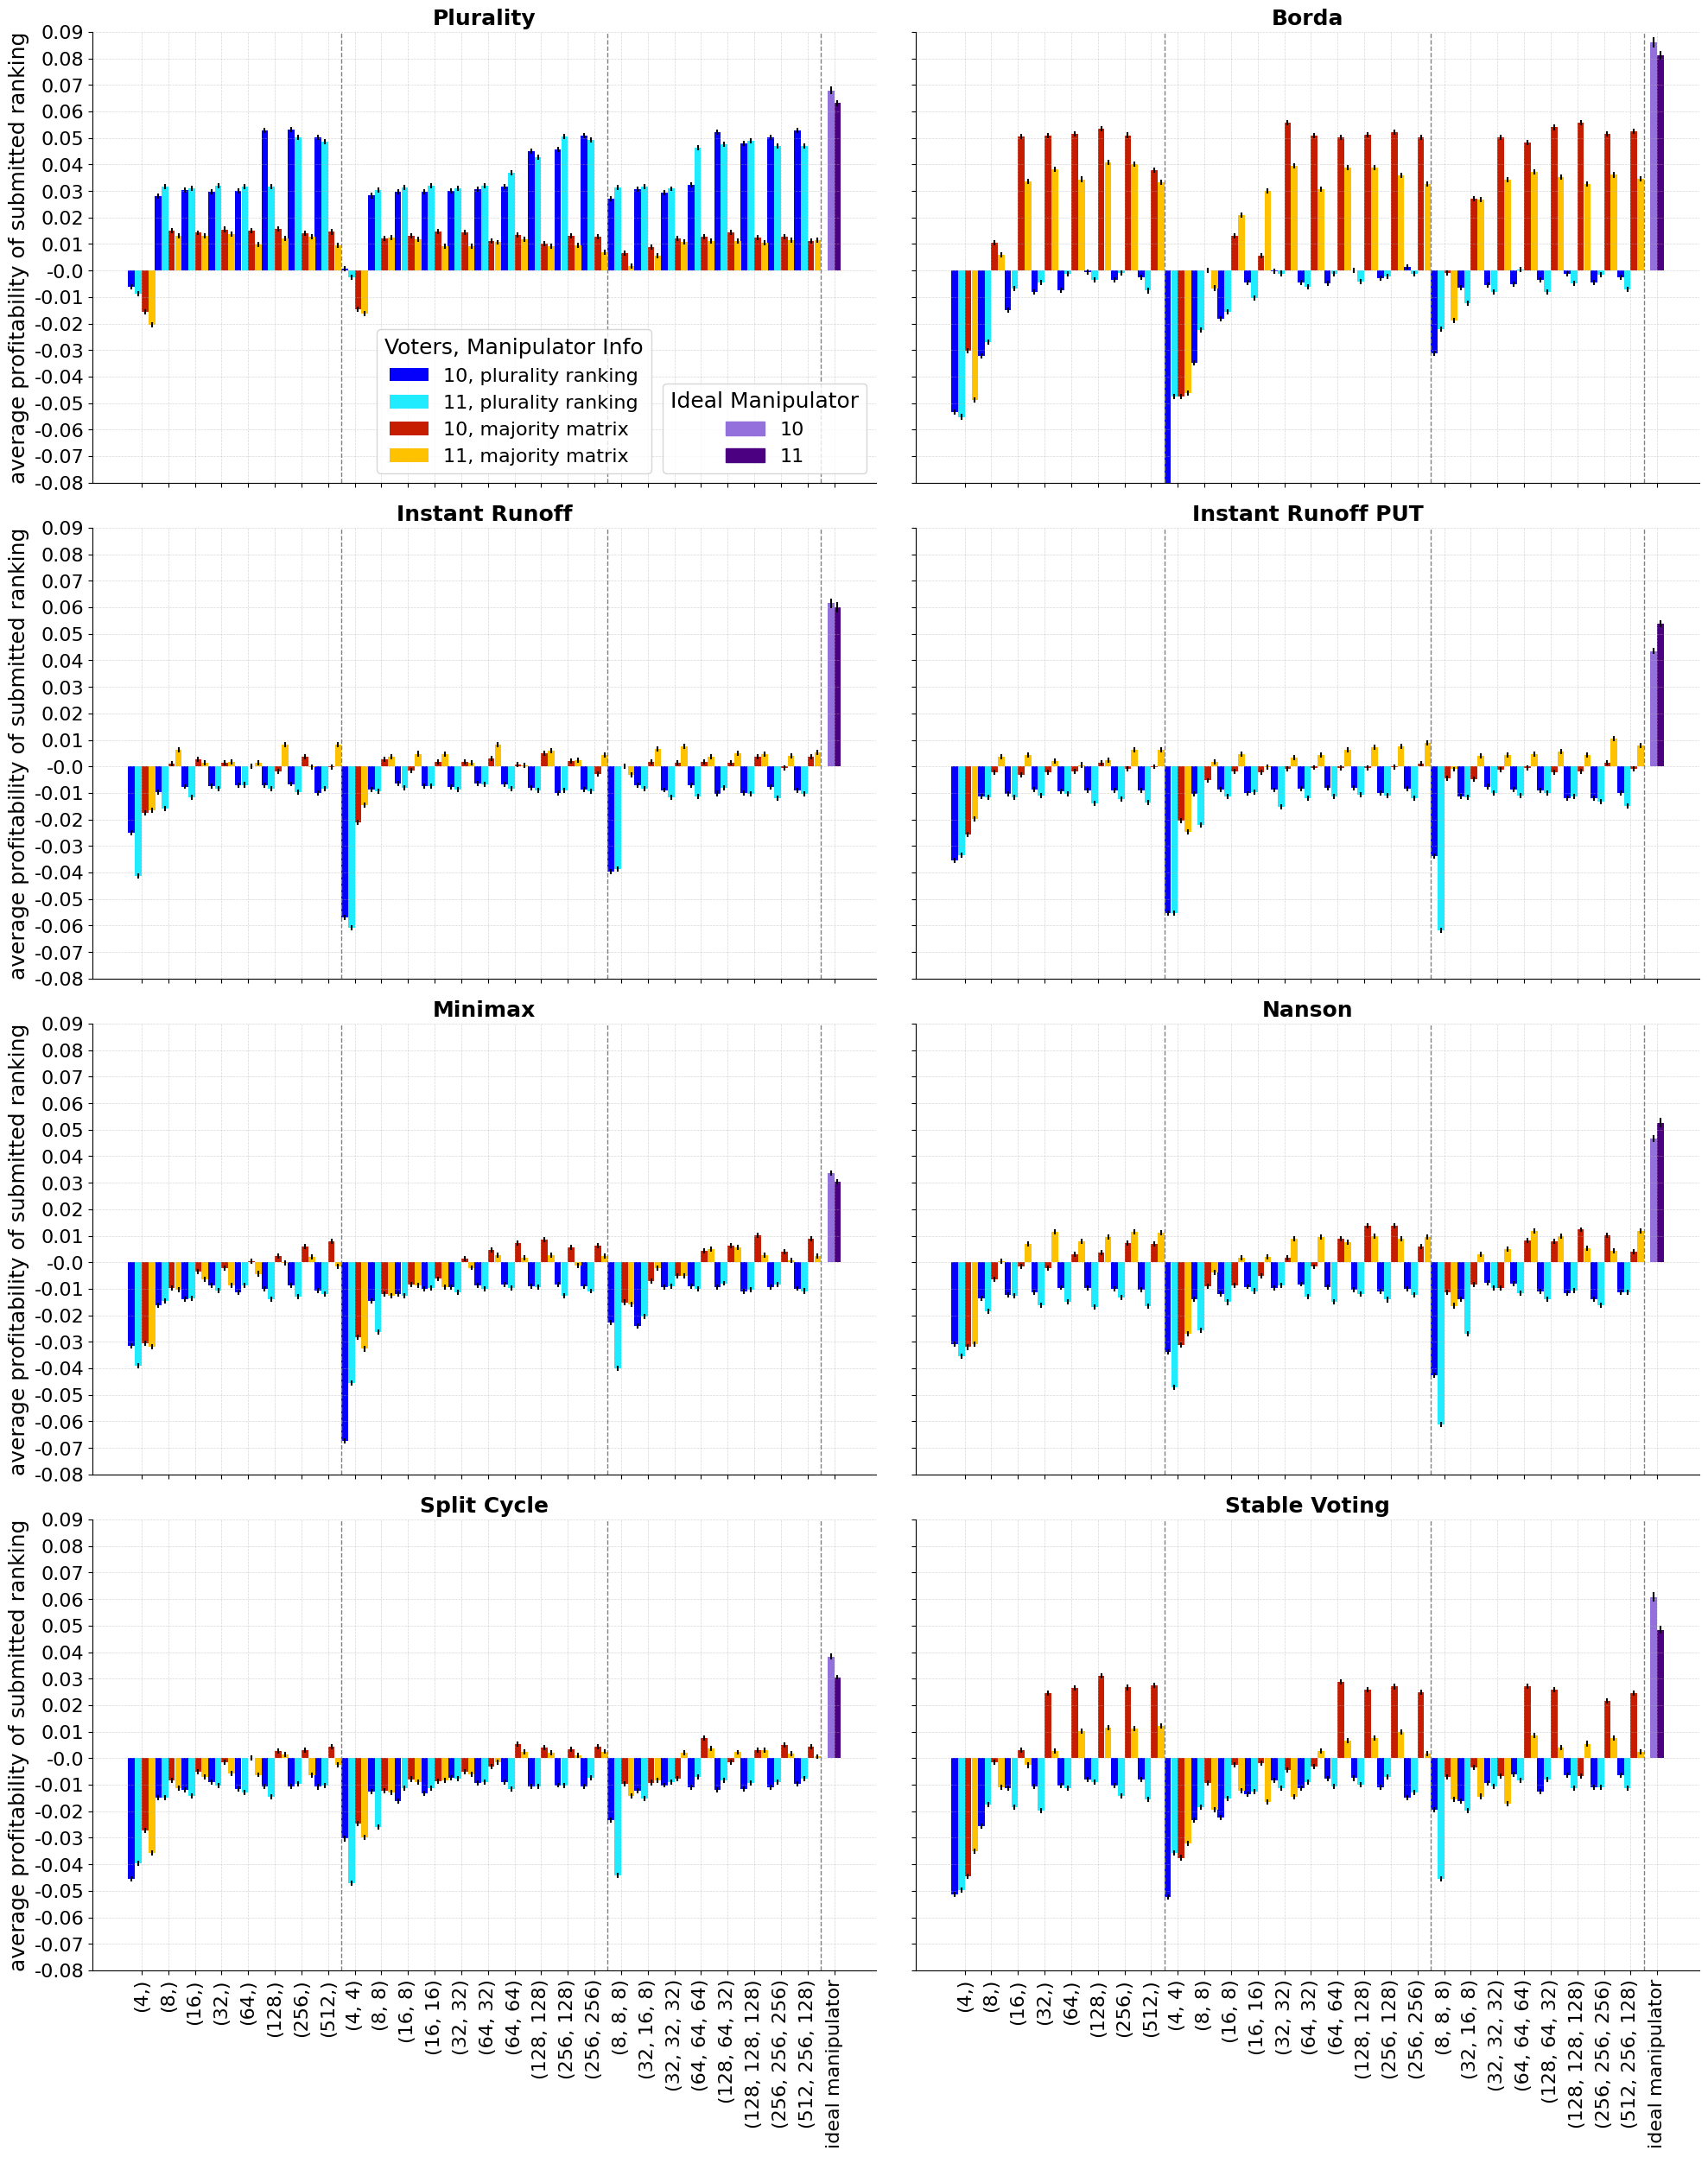

In [40]:
# generate the graphs

if VISUALIZE_RESULTS:
    filename = f"{graphs_dir}/graphs_{gen}_{num_cands}_{num_voters1, num_voters2}_{agent_infos1}_vs_{agent_infos2}_with_ideal.pdf"

    agent_infos = [agent_infos1]
    df_agent_infos1 = pd.read_csv(f"evaluation/evaluation_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/df_avg_{num_cands}_{agent_infos}_{manip_weight}_{gen}.csv")

    agent_infos = [agent_infos2]
    df_agent_infos2 = pd.read_csv(f"evaluation/evaluation_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/df_avg_{num_cands}_{agent_infos}_{manip_weight}_{gen}.csv")

    df_agent_infos1['agent_infos'] = agent_infos1
    df_agent_infos2['agent_infos'] = agent_infos2

    # Combining both dataframes again
    combined_df_new = pd.concat([df_agent_infos1, df_agent_infos2], ignore_index=True)

    # Creating the 'voters_info' column which combines the number of voters and agent_infos
    combined_df_new['voters_info'] = combined_df_new['num_voters'].astype(str) + ', ' + combined_df_new['agent_infos']

    color_dict = {
            f"{num_voters1}, {agent_infos1}": num_voters1_colors[agent_infos1],
            f"{num_voters2}, {agent_infos1}": num_voters2_colors[agent_infos1],
            f"{num_voters1}, {agent_infos2}": num_voters1_colors[agent_infos2],
            f"{num_voters2}, {agent_infos2}": num_voters2_colors[agent_infos2],
        }

    
    legend_label_mapping = {
            f"{num_voters1}, {agent_infos1}": f"{num_voters1}, {agent_infos1_str}",
            f"{num_voters2}, {agent_infos1}": f"{num_voters2}, {agent_infos1_str}",
            f"{num_voters1}, {agent_infos2}": f"{num_voters1}, {agent_infos2_str}",
            f"{num_voters2}, {agent_infos2}": f"{num_voters2}, {agent_infos2_str}"
        }

    if num_voters1 < num_voters2: 
        ideal_manipulators_df = pd.read_csv(f'ideal_manipulator_data/ideal_voter_1_uniform_{num_cands}_({num_voters1}, {num_voters2}).csv')
    else:
        ideal_manipulators_df = pd.read_csv(f'ideal_manipulator_data/ideal_voter_1_uniform_{num_cands}_({num_voters2}, {num_voters1}).csv')


    # Now calling the modified function with the provided arguments
    generate_graphs_with_errorbars(combined_df_new, ideal_manipulators_df[ideal_manipulators_df["num_cands"] == num_cands], num_cands, manip_weight, legend_label_mapping, color_dict, filename, labeling=labeling, probmodel=probmodel, gen=gen)


## 6.2. Graphs to compare manipulator information types for a fixed model size (Figure 1)

In [160]:
if VISUALIZE_RESULTS: 
    gen = 1
    all_num_cands = [3, 6]
    all_num_voters = [10, 11]
    manip_weight = 1

    all_agent_infos = [
        'plurality_scores',
        'plurality_ranking',
        'majority',
        'margin',
        'sincere_winners',
        'qual_margin']

    labeling = 'optimize'
    decision_rule = 'argmax'
    metric_op = 'normalized_subtract'
    probmodel = 'uniform'
    evaluation_batch_size = 4096
    max_est_std_error = 0.0005
    eval_dict = {}
    for num_cands in all_num_cands:
        for num_voters in all_num_voters: 
            for agent_info in all_agent_infos:
                # get filename from regular expression
                filenames = glob.glob(f"evaluation/evaluation_('{agent_info}',)_{probmodel}_{labeling}_{manip_weight}/{gen}_{num_cands}_{num_voters}_{probmodel}_('{agent_info}',)_{manip_weight}_{decision_rule}_{metric_op}_{evaluation_batch_size}_{max_est_std_error}_*.pickle")
                if len(filenames) == 0:
                    raise ValueError(f"no file found for {num_cands} candidates, {num_voters} voters, and {agent_info}\n")
                elif len(filenames) > 1:
                    raise ValueError("more than one file found!")
                     
                else: 
                    filename = filenames[0]
                    print(f"loading {agent_info} evaluation data:\n {filename.split('/')[-1]}")
                    _eval_dict  = pickle.load(open(filename, 'rb'))
                    eval_dict.update(_eval_dict)


    print(len(eval_dict.keys()))
    df = create_dataframe(eval_dict)
    df['agent_infos'] = df['agent_infos'].astype(str)
    df['agent_infos'] = df['agent_infos'].replace({
        "('plurality_scores',)": "plurality_scores", 
        "('majority',)": "majority",
        "('plurality_ranking',)": "plurality_ranking",
        "('margin',)": "margin",
        "('sincere_winners',)": "sincere_winners",
        "('qual_margin',)": "qual_margin",
        })

    df.to_csv("./evaluation/all_agent_infos_diff_cands.csv")

loading plurality_scores evaluation data:
 1_3_10_uniform_('plurality_scores',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_20-41-02.pickle
loading plurality_ranking evaluation data:
 1_3_10_uniform_('plurality_ranking',)_1_argmax_normalized_subtract_4096_0.0005_01-09-2024_15-43-00.pickle
loading majority evaluation data:
 1_3_10_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_20-41-02.pickle
loading margin evaluation data:
 1_3_10_uniform_('margin',)_1_argmax_normalized_subtract_4096_0.0005_01-09-2024_15-43-00.pickle
loading sincere_winners evaluation data:
 1_3_10_uniform_('sincere_winners',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_04-53-08.pickle
loading qual_margin evaluation data:
 1_3_10_uniform_('qual_margin',)_1_argmax_normalized_subtract_4096_0.0005_01-14-2024_02-56-20.pickle
loading plurality_scores evaluation data:
 1_3_11_uniform_('plurality_scores',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_20-41-02.pickle
loading pl

In [161]:
data_for_df = {
    "num_cands": list(),
    "num_voters": list(),
    "agent_infos": list(),
    "vm": list(),
    "mean_profitability": list(),
    "model_size": list(),
}

for num_cands in all_num_cands: 
    for num_voters in all_num_voters: 
        for vm in voting_methods_order: 
            for agent_infos in all_agent_infos:

                data_for_df["num_cands"].append(num_cands)
                data_for_df["num_voters"].append(num_voters)
                data_for_df["agent_infos"].append(agent_infos)
                data_for_df["vm"].append(vm)

                max_mean_profitability = df[(df['num_cands'] == num_cands) & (df['num_voters'] == num_voters) & (df['agent_infos'] == agent_infos) & (df['vm'] == vm)]['mean_profitability'].max()
                # find the model_size with the max mean_profitability
                model_size = df[(df['num_cands'] == num_cands) & (df['num_voters'] == num_voters) & (df['agent_infos'] == agent_infos) & (df['vm'] == vm) & (df['mean_profitability'] == max_mean_profitability)]['model_size'].values[0]

                data_for_df["mean_profitability"].append(max_mean_profitability)
                data_for_df["model_size"].append(model_size)
   
df_with_max = pd.DataFrame(data_for_df)


In [162]:
if VISUALIZE_RESULTS:


    # replace "Strict Nanson" with "Nanson" in the dataframe
    df_with_max['vm'] = df_with_max['vm'].replace('Strict Nanson', 'Nanson')

    filtered_df_all_agents = df_with_max[(df_with_max['num_cands'].isin(all_num_cands))]

    filtered_df_voters_all_agents = filtered_df_all_agents[filtered_df_all_agents['num_voters'].isin(all_num_voters)]

    grouped_df_all_agents = filtered_df_voters_all_agents.groupby(['vm', 'agent_infos']).mean_profitability.mean().unstack()

    specified_order = [ 
        "plurality_ranking", 
        "plurality_scores", 
        "majority", 
        "qual_margin", 
        "margin", 
        "sincere_winners"]
    grouped_df_ordered = grouped_df_all_agents[specified_order]


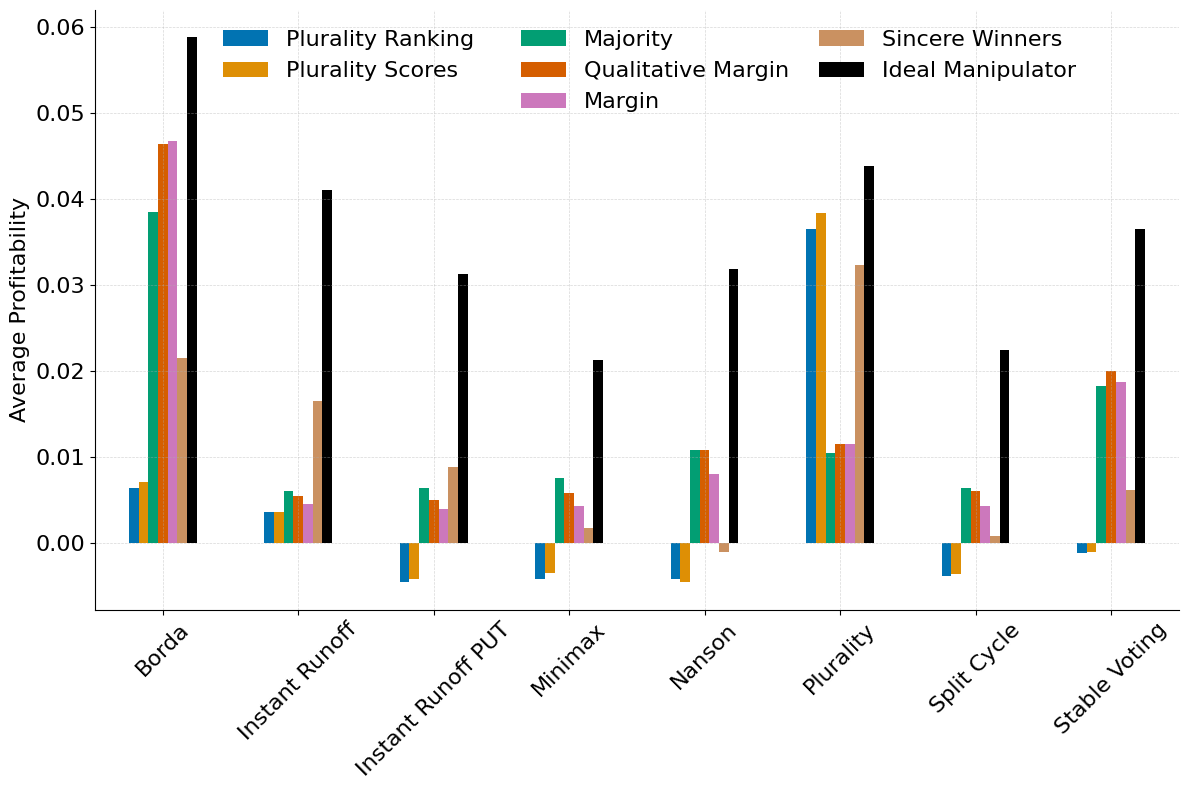

In [163]:
if VISUALIZE_RESULTS:
    # Load the two CSV files
    file_path_1 = './ideal_manipulator_data/ideal_voter_1_uniform_3_(10, 11).csv'
    file_path_2 = './ideal_manipulator_data/ideal_voter_1_uniform_6_(10, 11).csv'
    df1 = pd.read_csv(file_path_1)
    df2 = pd.read_csv(file_path_2)
    
    fontsize = 16

    # Combining the two dataframes
    combined_df = pd.concat([df1, df2])
    combined_df['vm'] = combined_df['vm'].replace('Strict Nanson', 'Nanson')


    # Filtering for 'max' decision_rule
    filtered_max_decision = combined_df[combined_df['decision_rule'] == 'max']

    # Grouping by voting method and calculating the average of 'mean' for 3 and 6 candidates and 10 and 11 voters
    average_means = filtered_max_decision.groupby('vm')['mean'].mean()

    # Adding the 'ideal manipulator' data to the previous bar graph data
    updated_grouped_df = grouped_df_ordered.assign(Ideal_Manipulator=average_means)
    updated_grouped_df = updated_grouped_df.fillna(0)  # Fill NaNs with 0 for plotting

    specified_order = [ 
        "plurality_ranking",
        "plurality_scores", 
        "majority", 
        "qual_margin", 
        "margin", 
        "sincere_winners", 
        "Ideal_Manipulator"]
    
    updated_grouped_df = updated_grouped_df[specified_order]

    colors=sns.color_palette("colorblind", len(updated_grouped_df.columns)-1) + ["black"]

    fig, ax = plt.subplots(figsize=(12, 8))
    updated_grouped_df.plot(kind='bar', 
                            ax=ax,
                            color=colors)


    ax.set_xlabel("")
    ax.set_ylabel("Average Profitability", fontsize=fontsize)
    ax.set_title("", fontsize=fontsize)

    # Updating the legend with readable labels
    readable_legend_labels = {
        "plurality_ranking": "Plurality Ranking",
        "plurality_scores": "Plurality Scores",
        "majority": "Majority",
        "qual_margin": "Qualitative Margin",
        "margin": "Margin",
        "sincere_winners": "Sincere Winners",
        "Ideal_Manipulator": "Ideal Manipulator"
    }

    handles, labels = ax.get_legend_handles_labels()
    handles = handles[1:] + handles[0:1]
    labels = labels[1:] + labels[0:1]

    new_labels = [readable_legend_labels.get(label, label) for label in labels]

    handles, labels = ax.get_legend_handles_labels()

    # Divide handles and labels into three groups
    handles_col1 = handles[:2]  
    labels_col1 = labels[:2]
    new_labels_col1 = [readable_legend_labels.get(label, label) for label in labels_col1]  
    
    handles_col2 = handles[2:5]  
    labels_col2 = labels[2:5]
    new_labels_col2 = [readable_legend_labels.get(label, label) for label in labels_col2]  

    handles_col3 = handles[5:7]  
    labels_col3 = labels[5:7]
    new_labels_col3 = [readable_legend_labels.get(label, label) for label in labels_col3]  

    leg_col1 = ax.legend(handles_col1, new_labels_col1, loc='upper left', bbox_to_anchor=(0.1, 1), ncol=1, frameon=False, fontsize=fontsize)

    leg_col2 = ax.legend(handles_col2, new_labels_col2, loc='upper left', bbox_to_anchor=(0.375, 1), ncol=1, frameon=False, fontsize=fontsize)

    leg_col3 = ax.legend(handles_col3, new_labels_col3, loc='upper left', bbox_to_anchor=(0.65, 1), ncol=1, frameon=False, fontsize=fontsize)

    # Add the legends back to the Axes
    ax.add_artist(leg_col1)
    ax.add_artist(leg_col2)


    plt.yticks(fontsize=fontsize)

    plt.xticks(rotation=45, fontsize=fontsize)
    sns.despine(right=True, top=True)
    # add grid lines
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"{graphs_dir}/voting_methods_different_agent_infos.pdf")
    plt.show()


### Ratio of mean profitability to the mean of the best possible profitability for a fixed model size

In [164]:
if VISUALIZE_RESULTS:
    # Copy the original dataframe
    df_ratio = updated_grouped_df.copy()

    # Applying the ratio transformation to each column except 'vm' and 'Ideal_Manipulator'
    for column in df_ratio.columns:
        if column != 'vm' and column != 'Ideal_Manipulator':
            df_ratio[column] = updated_grouped_df[column] / updated_grouped_df['Ideal_Manipulator']
    df_ratio

/var/folders/zw/wyk4bycs5sjb6lt2q2xgbf040000gn/T/ipykernel_36495/2562826397.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


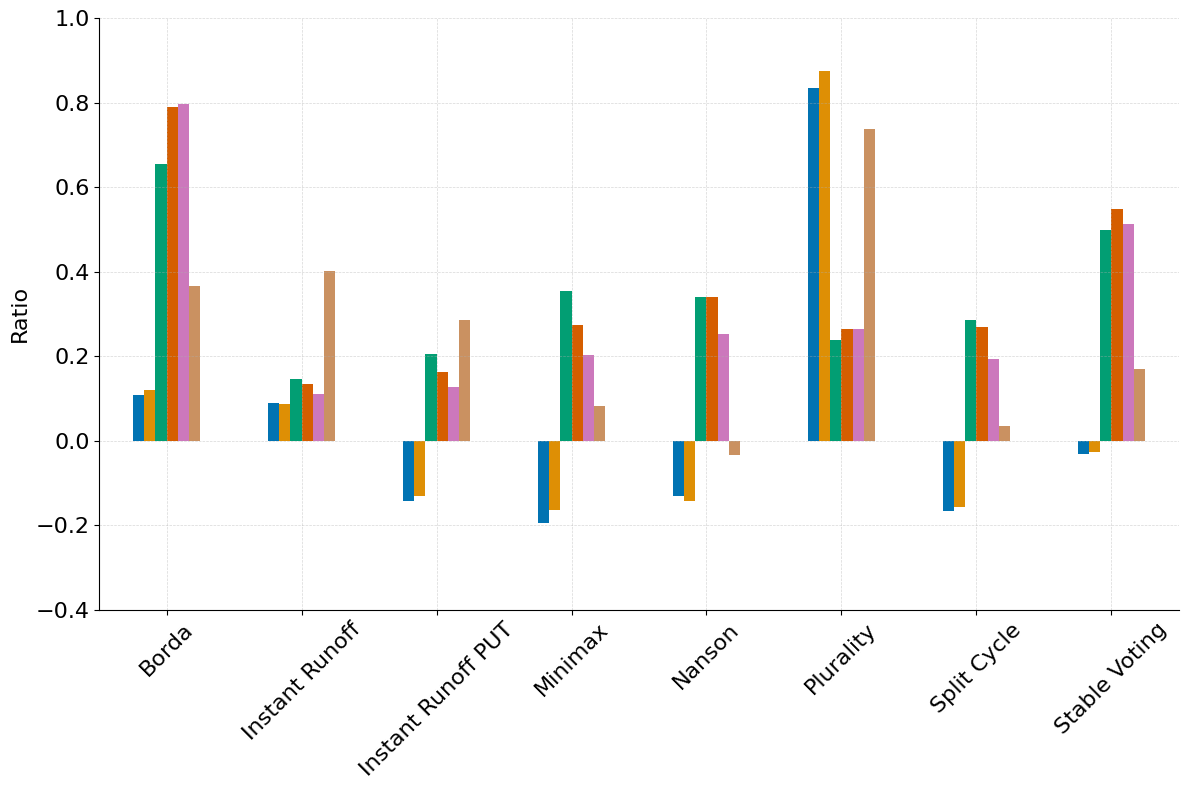

In [165]:
if VISUALIZE_RESULTS:
    # Reordering the columns in the dataframe to match the specified order
    specified_order = [ 
        "plurality_ranking", 
        "plurality_scores", 
        "majority", 
        "qual_margin", 
        "margin", 
        "sincere_winners"
        ]
    ratio_df_ordered = df_ratio[specified_order]

    colors=sns.color_palette("colorblind", len(updated_grouped_df.columns)-1) + ["black"]

    plt.style.use('seaborn-colorblind')
    fig, ax = plt.subplots(figsize=(12, 8))
    ratio_df_ordered.plot(kind='bar', ax=ax, color=colors)

    ax.set_xlabel("")
    ax.set_ylabel("Ratio",fontsize=fontsize)
    ax.set_title("",fontsize=fontsize)

    readable_legend_labels = {
        "plurality_ranking": "Plurality Ranking",
        "plurality_scores": "Plurality Scores",
        "majority": "Majority",
        "qual_margin": "Qualitative Margin",
        "margin": "Margin",
        "sincere_winners": "Sincere Winners",
        "Ideal_Manipulator": "Ideal Manipulator"
    }

    ax.get_legend().remove()

    plt.ylim(-0.4, 1.0)
    plt.yticks(fontsize=fontsize)
    plt.xticks(rotation=45, fontsize=fontsize)
    sns.despine(right=True, top=True)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"{graphs_dir}/voting_methods_different_agent_infos_ratio.pdf")
    plt.show()


## 6.3. Graphs to compare across different numbers of candidates (Figure 2)

In [177]:
if VISUALIZE_RESULTS: 
    gen = 1
    all_num_cands = [3, 4, 5, 6]
    all_num_voters = [5, 6, 10, 11, 20, 21]
    all_num_voters_pairs = [
        '(5, 6)', 
        '(10, 11)', 
        '(20, 21)'
    ] 
    manip_weight = 1
    agent_infos = 'majority'
    agent_infos_str = 'Majority Matrix'

    labeling = 'optimize'
    decision_rule = 'argmax'
    metric_op = 'normalized_subtract'
    probmodel = 'uniform'
    evaluation_batch_size = 4096
    max_est_std_error = 0.0005
    eval_dict = {}
    for num_cands in all_num_cands:
        for num_voters in all_num_voters: 
            # get filename from regular expression
            filenames = glob.glob(f"evaluation/evaluation_('{agent_infos}',)_{probmodel}_{labeling}_{manip_weight}/{gen}_{num_cands}_{num_voters}_{probmodel}_('{agent_infos}',)_{manip_weight}_{decision_rule}_{metric_op}_{evaluation_batch_size}_{max_est_std_error}_*.pickle")
            if len(filenames) == 0:
                raise ValueError(f"no file found for {num_cands} candidates, {num_voters} voters, and {agent_infos}\n")
            elif len(filenames) > 1:
                raise ValueError("more than one file found!")
                
            else: 
                filename = filenames[0]
                print(f"loading {agent_infos} evaluation data:\n {filename.split('/')[-1]}")
                _eval_dict  = pickle.load(open(filename, 'rb'))
                eval_dict.update(_eval_dict)

    print(len(eval_dict.keys()))
    df = create_dataframe(eval_dict)
    df['agent_infos'] = df['agent_infos'].astype(str)
    df['agent_infos'] = df['agent_infos'].replace({
        "('plurality_scores',)": "plurality_scores", 
        "('majority',)": "majority",
        "('plurality_ranking',)": "plurality_ranking",
        "('margin',)": "margin",
        "('qual_margin',)": "qual_margin",
        })


loading majority evaluation data:
 1_3_5_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_20-41-02.pickle
loading majority evaluation data:
 1_3_6_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_20-41-02.pickle
loading majority evaluation data:
 1_3_10_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_20-41-02.pickle
loading majority evaluation data:
 1_3_11_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_20-41-02.pickle
loading majority evaluation data:
 1_3_20_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_20-41-02.pickle
loading majority evaluation data:
 1_3_21_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_20-41-02.pickle
loading majority evaluation data:
 1_4_5_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-09-2024_15-40-42.pickle
loading majority evaluation data:
 1_4_6_uniform_('majority',)_1_argmax_normali

In [178]:
data_for_df = {
    "num_cands": list(),
    "num_voters": list(),
    "agent_infos": list(),
    "vm": list(),
    "mean_profitability": list(),
    "model_size": list(),
}

for num_cands in all_num_cands: 
    for num_voters in all_num_voters: 
        for vm in voting_methods_order: 
            data_for_df["num_cands"].append(num_cands)
            data_for_df["num_voters"].append(num_voters)
            data_for_df["agent_infos"].append(agent_infos)
            data_for_df["vm"].append(vm)

            max_mean_profitability = df[(df['num_cands'] == num_cands) & (df['num_voters'] == num_voters) & (df['agent_infos'] == agent_infos) & (df['vm'] == vm)]['mean_profitability'].max()
            
            # find the model_size with the max mean_profitability

            model_size = df[(df['num_cands'] == num_cands) & (df['num_voters'] == num_voters) & (df['agent_infos'] == agent_infos) & (df['vm'] == vm) & (df['mean_profitability'] == max_mean_profitability)]['model_size'].values[0]

            data_for_df["mean_profitability"].append(max_mean_profitability)
            data_for_df["model_size"].append(model_size)
   
df_with_max = pd.DataFrame(data_for_df)


In [179]:
if VISUALIZE_RESULTS: 
    dfs = []
    for num_cands in all_num_cands:
        for num_voters_pairs in all_num_voters_pairs:
            file_path = f'./ideal_manipulator_data/ideal_voter_1_uniform_{num_cands}_{num_voters_pairs}.csv'
            df = pd.read_csv(file_path)
            dfs.append(df)
    fontsize = 14
    # Combining the two dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
        
    combined_df['vm'] = combined_df['vm'].replace('Strict Nanson', 'Nanson')

    # Filtering for 'max' decision_rule
    filtered_max_decision = combined_df[combined_df['decision_rule'] == 'max']
    filtered_max_decision['num_cands_str'] = filtered_max_decision['num_cands'].astype(str)


/var/folders/zw/wyk4bycs5sjb6lt2q2xgbf040000gn/T/ipykernel_36495/440745900.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_max_decision['num_cands_str'] = filtered_max_decision['num_cands'].astype(str)


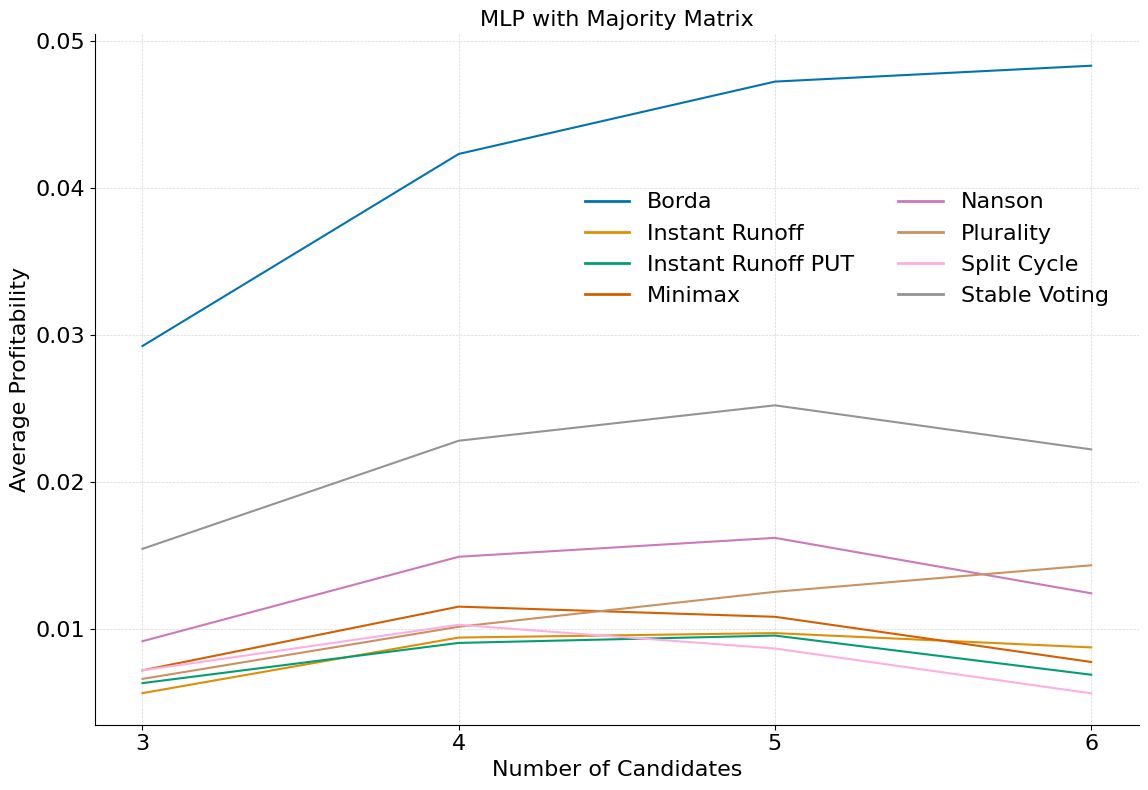

In [180]:

if VISUALIZE_RESULTS:

    # replace Strict Nanson with Nanson
    df_with_max['vm'] = df_with_max['vm'].replace('Strict Nanson', 'Nanson')
    fontsize=16
    df_with_max['num_cands_str'] = df_with_max['num_cands'].astype(str)

    # Extracting unique voting methods and preparing a color palette
    unique_vms = sorted(df_with_max['vm'].unique())
    palette = sns.color_palette("colorblind", n_colors=len(unique_vms))

    # Creating the plot
    plt.figure(figsize=(12, 8))

    # Plotting lines for each voting method and preparing legend elements
    legend_elements = []
    for i, vm in enumerate(unique_vms):

        _data = df_with_max[(df_with_max['vm'] == vm) & (df_with_max['agent_infos'] ==  agent_infos)]
        mean_profit_data = _data.pivot_table(index='num_cands_str', values='mean_profitability', aggfunc='mean')
        plt.plot(mean_profit_data.index, mean_profit_data.values, linestyle='-', color=palette[i])

        legend_elements.append(plt.Line2D([0], [0], color=palette[i], lw=2, label=vm))

    # Adding plot details
    plt.title(f'MLP with {agent_infos_str}', fontsize=fontsize)
    plt.xlabel('Number of Candidates', fontsize=fontsize)
    plt.ylabel('Average Profitability', fontsize=fontsize)

    # Adding the legend with only solid lines for voting methods
    plt.legend(handles=legend_elements, title='', loc='upper left', bbox_to_anchor=(0.45, 0.8), fontsize=fontsize, ncols=2, frameon=False)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    sns.despine(right=True, top=True)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"{graphs_dir}/num_cands_different_voting_methods_{agent_infos}.pdf")
    plt.show()


### Ideal manipulator

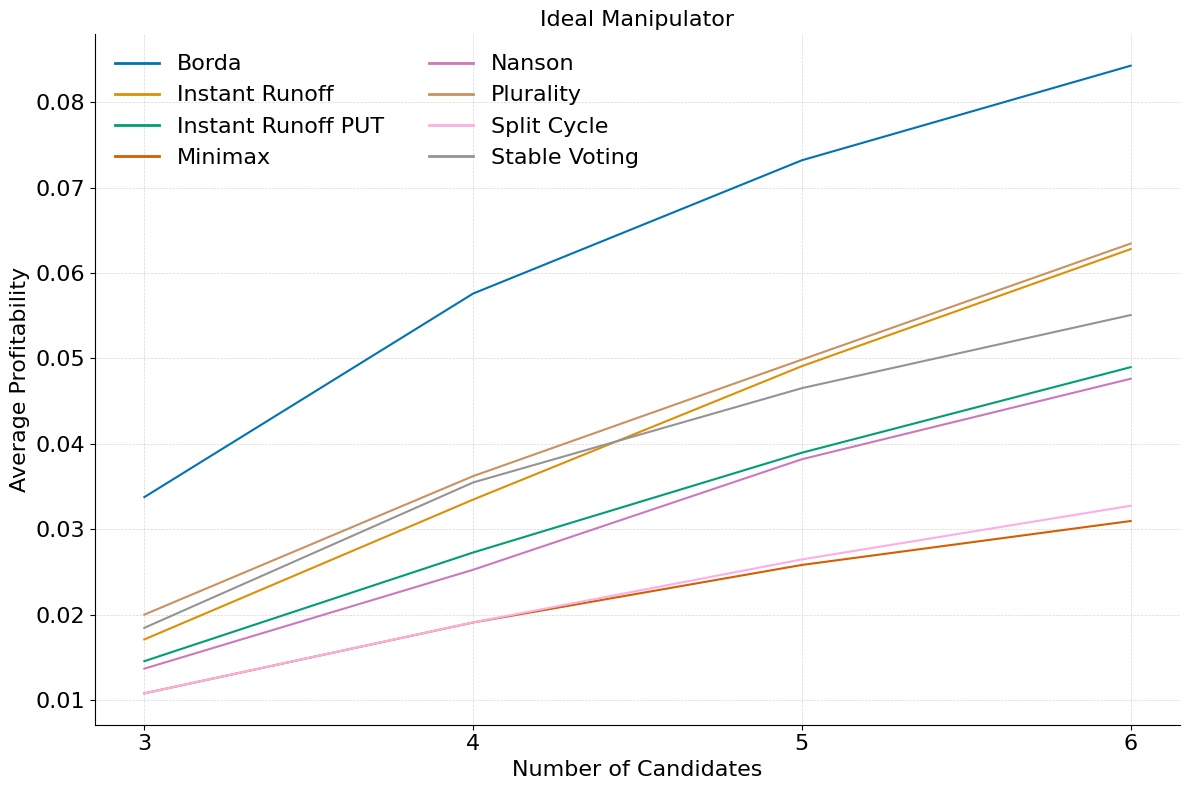

In [181]:
if VISUALIZE_RESULTS:
 
    # replace Strict Nanson with Nanson
    df_fixed_model_size['vm'] = df_fixed_model_size['vm'].replace('Strict Nanson', 'Nanson')
    
    fontsize=16

    df_fixed_model_size['num_cands_str'] = df_fixed_model_size['num_cands'].astype(str)

    unique_vms = sorted(df_fixed_model_size['vm'].unique())
    palette = sns.color_palette("colorblind", n_colors=len(unique_vms))

    plt.figure(figsize=(12, 8))

    legend_elements = []

    for i, vm in enumerate(unique_vms):

        ideal_data = filtered_max_decision[filtered_max_decision['vm'] == vm]
        ideal_data_avg = ideal_data.pivot_table(index='num_cands_str', values='mean', aggfunc='mean')

        plt.plot(ideal_data_avg.index, ideal_data_avg.values, linestyle='-', color=palette[i])

        legend_elements.append(plt.Line2D([0], [0], color=palette[i], lw=2, label=vm))

    plt.title('Ideal Manipulator', fontsize=fontsize)
    plt.xlabel('Number of Candidates', fontsize=fontsize)
    plt.ylabel('Average Profitability', fontsize=fontsize)

    plt.legend(handles=legend_elements, title='', loc='upper left', bbox_to_anchor=(0., 1.0), fontsize=fontsize, ncols=2, frameon=False)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    sns.despine(right=True, top=True)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"{graphs_dir}/num_cands_different_voting_methods_ideal.pdf")
    plt.show()


### Ratio of mean profitability to the mean of the best possible profitability for a fixed model size

In [182]:
if VISUALIZE_RESULTS:
    dfs = []
    for num_cands in all_num_cands:
        for num_voters_pairs in all_num_voters_pairs:
            file_path = f'./ideal_manipulator_data/ideal_voter_1_uniform_{num_cands}_{num_voters_pairs}.csv'
            df = pd.read_csv(file_path)
            dfs.append(df)
    fontsize = 14
    # Combining the two dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
        
    combined_df['vm'] = combined_df['vm'].replace('Strict Nanson', 'Nanson')

    # Filtering for 'max' decision_rule
    filtered_max_decision = combined_df[combined_df['decision_rule'] == 'max']

    df_with_max_ratio = df_with_max.copy()
    df_with_max_ratio['vm'] = df_with_max_ratio['vm'].replace('Strict Nanson', 'Nanson')

    data_for_df = {
        'vm': list(), 
        'num_cands': list(),
        "agent_infos": list(),
        "ratio": list(),
    }

    for num_cands in all_num_cands:
        for vm in voting_methods_order:
            if vm == "Strict Nanson": 
                vm = "Nanson"
            ideal_voter_mean = filtered_max_decision[(filtered_max_decision["num_cands"] == num_cands) & (filtered_max_decision['vm'] == vm)]['mean'].mean()
            
            # # # get the mean of the current vm for the same number of candidates and voters
            vm_mean = df_with_max_ratio[(df_with_max_ratio["num_cands"] == num_cands) & ((df_with_max_ratio['vm'] == vm) & (df_with_max_ratio['agent_infos'] == agent_infos))]['mean_profitability'].mean()
                                # calculate the ratio
            ratio = vm_mean / ideal_voter_mean
                            # add the ratio to the dataframe
            data_for_df['vm'].append(vm)
            data_for_df['num_cands'].append(num_cands)
            data_for_df['agent_infos'].append(agent_infos)
            data_for_df['ratio'].append(ratio)

    df_with_max_ratio = pd.DataFrame(data_for_df)


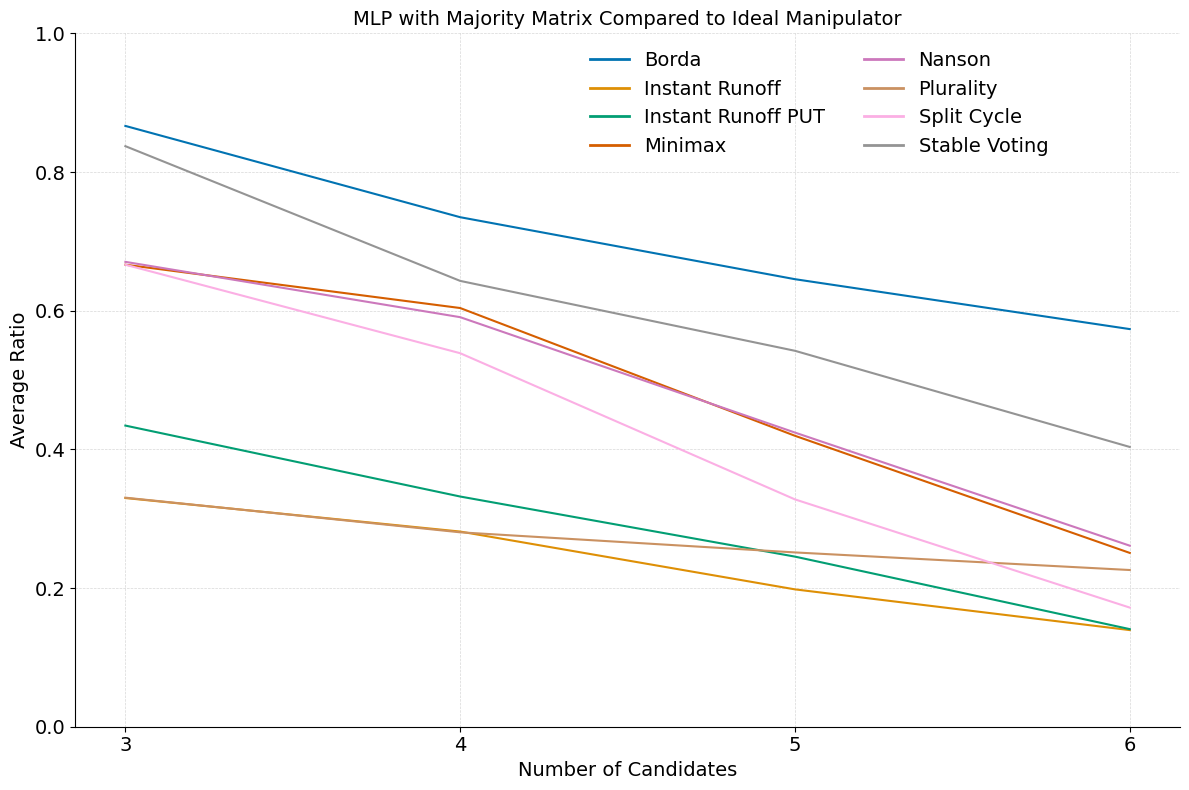

In [183]:
if VISUALIZE_RESULTS:
    
    df_with_max_ratio['num_cands_str'] = df_with_max_ratio['num_cands'].astype(str)

    unique_vms = sorted(df_with_max_ratio['vm'].unique())
    palette = sns.color_palette("colorblind", n_colors=len(unique_vms))

    plt.figure(figsize=(12, 8))

    legend_elements = []
    for i, vm in enumerate(unique_vms):

        _data = df_with_max_ratio[(df_with_max_ratio['vm'] == vm) & (df_with_max_ratio['agent_infos'] == agent_infos)]
        
        ratio_data = _data.pivot_table(index='num_cands_str', values='ratio', aggfunc='mean')

        plt.plot(ratio_data.index, ratio_data.values, linestyle='-', color=palette[i])

        legend_elements.append(plt.Line2D([0], [0], color=palette[i], lw=2, label=vm))

    # Adding plot details
    plt.title(f'MLP with {agent_infos_str} Compared to Ideal Manipulator', fontsize=fontsize)
    plt.xlabel('Number of Candidates', fontsize=fontsize)
    plt.ylabel('Average Ratio', fontsize=fontsize)
    min_ratio = df_with_max_ratio['ratio'].min()
    plt.ylim(min_ratio if min_ratio < 0 else 0.0, 1.0)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    # Adding the legend with only solid lines for voting methods
    plt.legend(handles=legend_elements, title='', loc='upper left', bbox_to_anchor=(0.45, 1.0), fontsize=fontsize, ncols=2, frameon=False)

    sns.despine(right=True, top=True)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

    plt.tight_layout()
    plt.savefig(f"{graphs_dir}/num_cands_different_voting_methods_{agent_infos}_ratio.pdf")
    plt.show()


##  6.4. Compare different generations of models

In [143]:
if VISUALIZE_RESULTS:
    num_cands = 6
    num_voters = 11
    agent_info = 'majority'
    agent_info_str = 'majority matrix'
    barcolor = 'orange' #'blue' #'green' #'red' #'orange' #'purple' #'brown'
    manip_weight = 1
    probmodel = 'uniform'
    labeling = 'optimize'

    print(f"loading {agent_info} evaluation data, generation 1")
    filename = glob.glob(f"evaluation/evaluation_('{agent_info}',)_{probmodel}_{labeling}_{manip_weight}/1_{num_cands}_{num_voters}_{probmodel}_('{agent_info}',)_{manip_weight}_*.pickle")[0]
    print(f"{filename.split('/')[-1]}")
    eval1 = pickle.load(open(filename, 'rb'))

    print(f"loading {agent_info} evaluation data, generation 2")
    filename = glob.glob(f"evaluation/evaluation_('{agent_info}',)_{probmodel}_{labeling}_{manip_weight}/2_{num_cands}_{num_voters}_{probmodel}_('{agent_info}',)_{manip_weight}_*.pickle")[0]
    print(f"{filename.split('/')[-1]}")
    eval2 = pickle.load(open(filename, 'rb'))


    print(f"loading {agent_info} evaluation data, generation 3")
    filename = glob.glob(f"evaluation/evaluation_('{agent_info}',)_{probmodel}_{labeling}_{manip_weight}/3_{num_cands}_{num_voters}_{probmodel}_('{agent_info}',)_{manip_weight}_*.pickle")[0]
    print(f"{filename.split('/')[-1]}")
    eval3 = pickle.load(open(filename, 'rb'))
    df1 = create_dataframe(eval1)
    df2 = create_dataframe(eval2)
    df3 = create_dataframe(eval3)
    dfs = {
        ((f'{agent_info}',), 1): df1,
        ((f'{agent_info}',), 2): df2,
        ((f'{agent_info}',), 3): df3,
    }

loading majority evaluation data, generation 1
1_6_11_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_07-02-44.pickle
loading majority evaluation data, generation 2
2_6_11_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_07-02-44.pickle
loading majority evaluation data, generation 3
3_6_11_uniform_('majority',)_1_argmax_normalized_subtract_4096_0.0005_01-10-2024_07-02-44.pickle
Finished creating dataframe for generation 1 and agent_infos ('majority',)
Finished creating dataframe for generation 2 and agent_infos ('majority',)
Finished creating dataframe for generation 3 and agent_infos ('majority',)


In [144]:
def generate_graphs_with_errorbars_for_different_generations(df, num_cands, manip_weight, legend_label_mapping, color_dict, filename, labeling='satisfice', probmodel='uniform'):
    # function to display graphs comparing 3 generations of models
    
    # multiply the est_std_errors by 2 to get 95% confidence intervals
    df['est_std_error'] = df['est_std_error'] * 2
    
    fontsize=16
    df = df[df['labeling'] == labeling]
    y_ticks = list(np.arange(-0.08, 0.10, 0.01))
    df = df[df['model_size'].isin(model_sizes_order)]
    df['model_size'] = pd.Categorical(df['model_size'], categories=model_sizes_order, ordered=True)
    df.sort_values('model_size', inplace=True)
    
    fig = plt.figure(figsize=(24, 33))
    gs = fig.add_gridspec(len(voting_methods_order) // 2, 2, hspace=0.1, wspace=0.05)
    
    voters_order = list(legend_label_mapping.keys())
    bar_offset = [-0.25, 0, 0.25]
        
    
    # Adjusted vertical line positions
    vline_positions = [model_sizes_order.index("(512,)"), model_sizes_order.index("(256, 256)")]
    
    
    for i, voting_method in enumerate(voting_methods_order):
        ax = fig.add_subplot(gs[i // 2, i % 2])
        df_filtered_vm = df[df['vm'] == voting_method]
        
        # Existing bars
        for idx, voter_info in enumerate(voters_order):
            current_data = df_filtered_vm[df_filtered_vm['voters_info'] == voter_info]
            ax.bar(x=np.arange(len(model_sizes_order)) + bar_offset[idx], height=current_data['average_mean_profitability'],
                   yerr=current_data['est_std_error'], width=0.25, align='center', label=legend_label_mapping[voter_info] if i == 0 else "", color=color_dict[voter_info])
        
        # Drawing the vertical dashed lines
        for pos in vline_positions:
            ax.axvline(x=pos + 0.5, color='gray', linestyle='--', linewidth=1)
        
        # Other plotting settings remain the same
        ax.set_title(f'{voting_method if voting_method != "Strict Nanson" else "Nanson"}', fontsize=18, weight='bold')
        ax.tick_params(axis='x', rotation=90, labelsize=8 if i // 2 == (len(voting_methods_order) // 2 - 1) else 0)
        ax.tick_params(axis='y', labelsize=10 if i % 2 == 0 else 0)
        ax.set_yticks(y_ticks)
        ax.set_ylim([-0.08, 0.09])
        ax.set_yticklabels([round(y,2) for y in y_ticks] if i % 2 == 0 else [], fontsize=fontsize)
        ax.set_xticks(list(np.arange(len(model_sizes_order))))
        ax.set_xticklabels(model_sizes_order  if i // 2 == (len(voting_methods_order) // 2 - 1) else [], fontsize=fontsize)
        ax.set_ylabel('average profitability of submitted ranking' if i % 2 == 0 else '', fontsize=18)
        ax.set_xlabel('')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
        
        if i == 0:
            # Main legend
            legend1 = ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0), title="Voters, Manipulator Info, Generation", title_fontsize = 18, fontsize=fontsize)
            ax.add_artist(legend1)
            

    plt.subplots_adjust(hspace=0.0, wspace=0.0, top=.83, bottom=0.15)
    plt.savefig(filename)
    plt.tight_layout()
    plt.show()


In [145]:
def create_average_dfs(
        dfs, 
        agent_infos_gen_list, 
        num_cands_list, 
        manip_weight_list,
        probmodel,
        labeling):
    # function to generate the dataframes for the graphs 
    # in the supplemental material
    for num_cands in num_cands_list:
        for agent_infos, gen in agent_infos_gen_list:
            print(agent_infos)
            print(gen)
            for manip_weight in manip_weight_list:
                    
                df = dfs[(tuple(agent_infos), gen)]
                df_avg_10 = generate_avg_df(df[(df["num_cands"] == num_cands) & (df["num_voters"]==10)], num_cands, 10,  tuple(agent_infos), manip_weight, labeling, probmodel)
                    
                df_avg_11 = generate_avg_df(df[(df["num_cands"] == num_cands) & (df["num_voters"]==11)], num_cands, 11,  tuple(agent_infos), manip_weight, labeling, probmodel)
                    
                df_avg = pd.concat([df_avg_10, df_avg_11])
                print("generated ", f"evaluation/evaluation_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/df_avg_{num_cands}_{agent_infos}_{manip_weight}_{gen}.csv")
                    
                df_avg.to_csv(f"evaluation/evaluation_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/df_avg_{num_cands}_{agent_infos}_{manip_weight}_{gen}.csv")

In [146]:
def generate_combined_df(num_cands, num_voters, color_dict, legend_label_mapping, agent_infos,  manip_weight, labeling, probmodel, filename):
    # combined the dataframes produced by create_average_dfs
    
    gen=1
    _df1 = pd.read_csv(f"evaluation/evaluation_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/df_avg_{num_cands}_{list(agent_infos)}_{manip_weight}_{gen}.csv")
    df1 = _df1[_df1["num_voters"] == num_voters]
    df1['agent_infos'] = f'{agent_infos[0]}, 1'

    gen=2
    _df2 = pd.read_csv(f"evaluation/evaluation_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/df_avg_{num_cands}_{list(agent_infos)}_{manip_weight}_{gen}.csv")
    df2 = _df2[_df2["num_voters"] == num_voters]
    df2['agent_infos'] = f'{agent_infos[0]}, 2'

    gen=3
    agent_infos2=['plurality_scores']
    _df3 = pd.read_csv(f"evaluation/evaluation_{tuple(agent_infos)}_{probmodel}_{labeling}_{manip_weight}/df_avg_{num_cands}_{list(agent_infos)}_{manip_weight}_{gen}.csv")
    df3 = _df3[_df3["num_voters"] ==  num_voters]
    df3['agent_infos'] = f'{agent_infos[0]}, 3'

    combined_df = pd.concat([df1, df2, df3], ignore_index=True)

    # Create the 'voters_info' column which combines the number of voters and agent_infos

    combined_df['voters_info'] = combined_df['num_voters'].astype(str) + ', ' + combined_df['agent_infos']

    return combined_df


In [147]:
if VISUALIZE_RESULTS:
    agent_infos_gen_list = [
        [[f'{agent_info}'], 1], 
        [[f'{agent_info}'], 2],
        [[f'{agent_info}'], 3],
        ]
    manip_weight_list = [manip_weight]
    num_cands_list = [num_cands]

    create_average_dfs(dfs, agent_infos_gen_list, num_cands_list, manip_weight_list, probmodel, labeling)


['majority']
1
generated  evaluation/evaluation_('majority',)_uniform_optimize_1/df_avg_6_['majority']_1_1.csv
['majority']
2
generated  evaluation/evaluation_('majority',)_uniform_optimize_1/df_avg_6_['majority']_1_2.csv
['majority']
3
generated  evaluation/evaluation_('majority',)_uniform_optimize_1/df_avg_6_['majority']_1_3.csv


/var/folders/zw/wyk4bycs5sjb6lt2q2xgbf040000gn/T/ipykernel_36495/1694467681.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


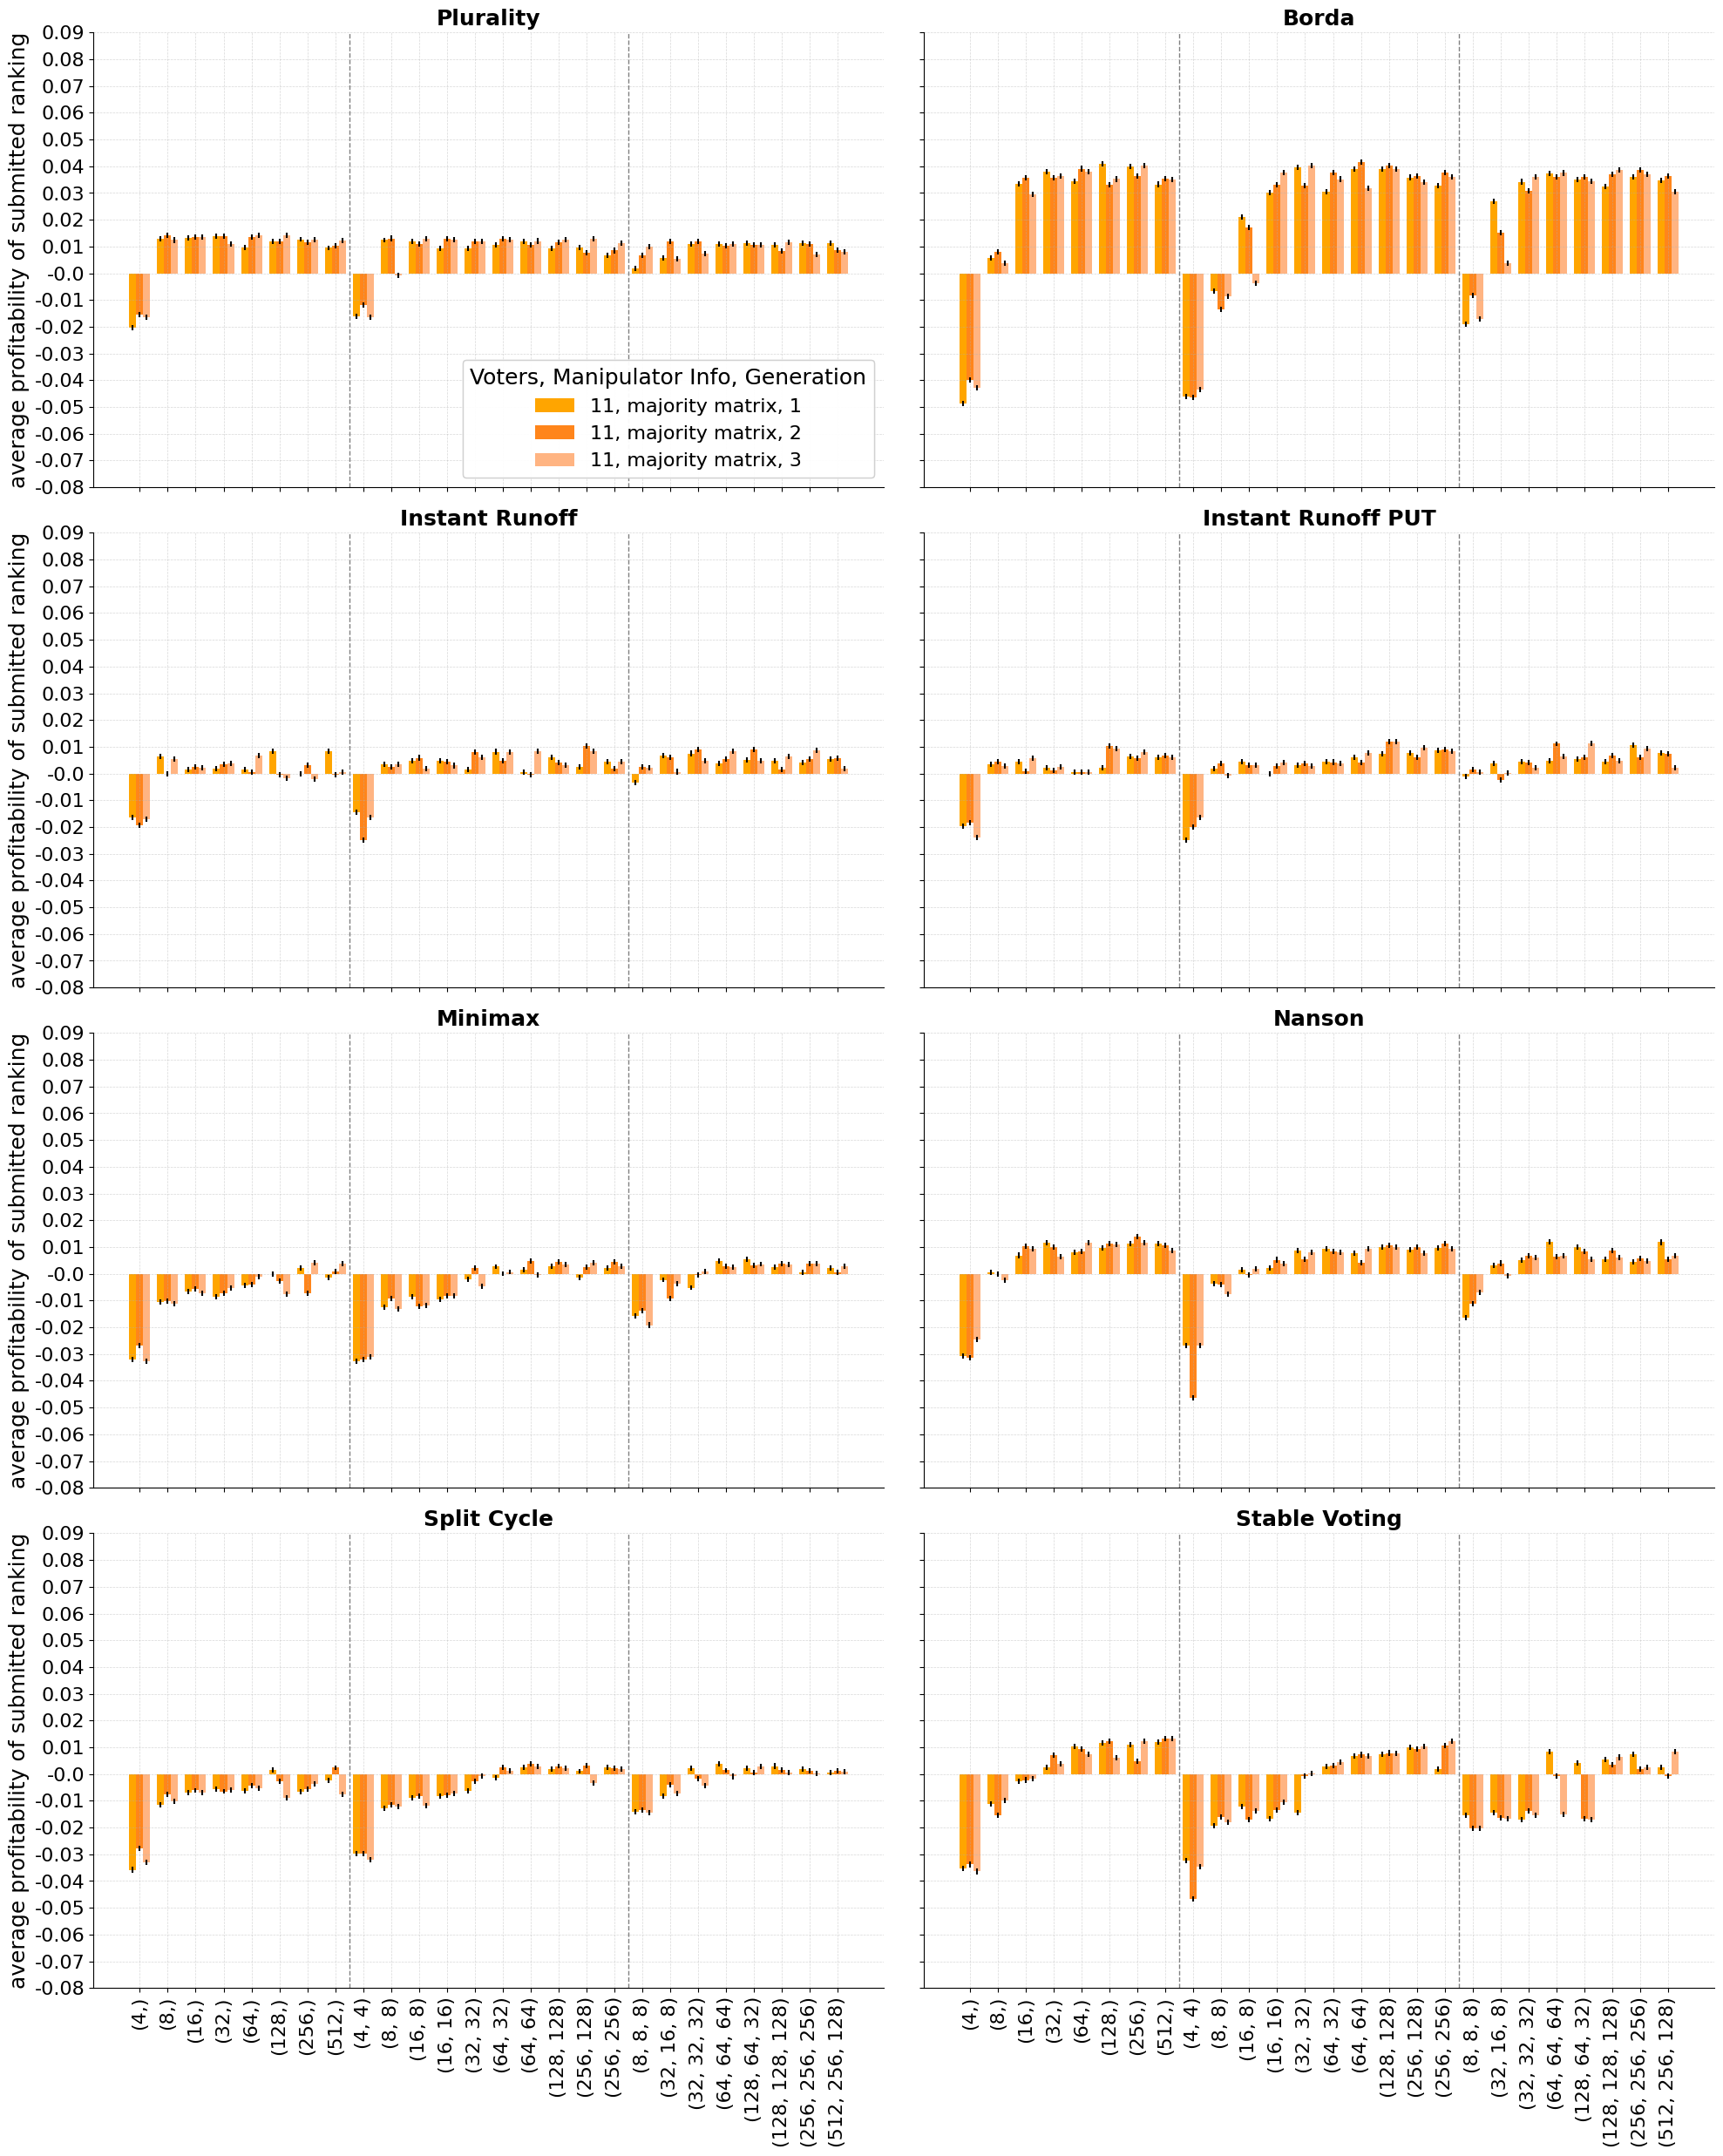

In [148]:
if VISUALIZE_RESULTS:

    agent_infos = [agent_info]
    color_dict = {
        f"{num_voters}, {agent_info}, 1": colors_for_bars[barcolor],
        f"{num_voters}, {agent_info}, 2": dark[barcolor],
        f"{num_voters}, {agent_info}, 3": pastel[barcolor],
    }
    
    legend_label_mapping = {
            f"{num_voters}, {agent_info}, 1": f"{num_voters}, {agent_info_str}, 1",
            f"{num_voters}, {agent_info}, 2": f"{num_voters}, {agent_info_str}, 2",
            f"{num_voters}, {agent_info}, 3": f"{num_voters}, {agent_info_str}, 3",
        }

    filename = f"{graphs_dir}/graphs_{num_cands}_{num_voters}_{agent_info}_3generations.pdf"

    combined_df = generate_combined_df(num_cands, num_voters, color_dict, legend_label_mapping, agent_infos, manip_weight, labeling, probmodel, filename)

    generate_graphs_with_errorbars_for_different_generations(combined_df, num_cands, manip_weight, legend_label_mapping, color_dict, filename, labeling=labeling, probmodel=probmodel)


## 6.5. Statistics about the number of models evaluated (Footnote 8)

In [ ]:
num_eval_files = 0
total_eval_dict = {}
eval_directories = [
    "evaluation_('majority',)_uniform_optimize_1",
    "evaluation_('margin',)_uniform_optimize_1",
    "evaluation_('plurality_ranking',)_uniform_optimize_1",
    "evaluation_('plurality_scores',)_uniform_optimize_1",
    "evaluation_('qual_margin',)_uniform_optimize_1",
    "evaluation_('sincere_winners',)_uniform_optimize_1",
]    
for eval_dir in eval_directories:

    for filename in glob.glob(f"evaluation/{eval_dir}/*.pickle"):
        num_eval_files += 1
        #print(f"loading {filename.split('/')[-1]}")
        _eval_dict  = pickle.load(open(filename, 'rb'))
        total_eval_dict.update(_eval_dict)
print(f"Number of evaluation files: {num_eval_files}")

In [ ]:
all_num_trials = []
for key in total_eval_dict.keys():
    all_num_trials.append(total_eval_dict[key]['num_trials'])
        
print("MIN ", min(all_num_trials))
print("MAX ", max(all_num_trials))
print("MEAN ", np.mean(all_num_trials))
print("STD ", np.std(all_num_trials))


## 6.6. The total number of model evaluated

In [ ]:
# Note that the models are not saved in this repo because they are too large, so this code will not run unless you have the models saved locally. 

num_model_files = 0
num_models = 0
num_training_iters = []
models_directories = [
    "models_('majority',)_uniform_optimize_1",
    "models_('margin',)_uniform_optimize_1",
    "models_('plurality_ranking',)_uniform_optimize_1",
    "models_('plurality_scores',)_uniform_optimize_1",
    "models_('qual_margin',)_uniform_optimize_1",
    "models_('sincere_winners',)_uniform_optimize_1",
]    
for model_dir in tqdm(models_directories, leave=False):
    for filename in glob.glob(f"models/{model_dir}/*.pickle"):
        num_model_files += 1
        #print(f"loading {filename.split('/')[-1]}")
        _model_dict  = pickle.load(open(filename, 'rb'))

        for key in _model_dict.keys(): 
            num_training_iters.append(len(_model_dict[key][1]))
        num_models += len(_model_dict.keys())

print(f"Number of models files: {num_model_files}")
print(f"The total number of models: {num_models}")

print("\n")

print(f"max number of iterations during training: {max(num_training_iters)}")
print(f"min number of iterations during training: {min(num_training_iters)}")
print(f"average number of iterations during training: {np.mean(num_training_iters)}")
print(f"standard deviation of the number of iterations during training: {np.std(num_training_iters)}")
